In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
data = pd.read_parquet('/main/data/MVideo_2/dataset_main_5_2.parquet')

In [4]:
data[['PRODUCT_ID', 'MAINCATEGORY_ID', 'SUBCATEGORY_ID',
       'STORE_ID', 'REGION', 'INTERNET',
       'WEEK(DATE)', 'MONTH(DATE)', 'CLUSTER']] = data[['PRODUCT_ID', 'MAINCATEGORY_ID', 'SUBCATEGORY_ID',
                                                          'STORE_ID', 'REGION', 'INTERNET',
                                                          'WEEK(DATE)', 'MONTH(DATE)', 'CLUSTER']].astype('category')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2831698 entries, 0 to 2831697
Columns: 132 entries, DATE to NUM_STORES
dtypes: category(9), datetime64[ns](1), float32(102), int32(20)
memory usage: 1.4 GB


In [6]:
data_train = data[data.DATE < '2018-03-18']

In [7]:
data_train.shape[0]

2377102

In [8]:
data_val = data[(data.DATE >= '2018-03-18') & (data.DATE < '2018-05-13')]

In [9]:
data_val.shape[0]

226359

In [10]:
data_test = data[data.DATE >= '2018-05-13']

In [11]:
data_test.shape[0]

228237

In [12]:
feat = [s for s in data.columns if s not in ['DATE', 'UNITS_SOLD_P1']]

In [13]:
dts = lgb.Dataset(data_train[feat], label = data_train.UNITS_SOLD_P1)

In [14]:
dts = dts.construct()

In [15]:
dtsv = dts.create_valid(data_val[feat], label = data_val.UNITS_SOLD_P1)

In [16]:
params = {
    'application': 'regression_l2',
    'learning_rate': 0.03,
    'num_leaves': 511,
    'metric': 'l2_root'
    }

In [17]:
bst = lgb.train(params, dts, valid_sets = [dtsv], valid_names = ['Validation'],
                num_boost_round = 10000, early_stopping_rounds = 20)

[1]	Validation's rmse: 0.887501
Training until validation scores don't improve for 20 rounds.
[2]	Validation's rmse: 0.882128
[3]	Validation's rmse: 0.876888
[4]	Validation's rmse: 0.87217
[5]	Validation's rmse: 0.867725
[6]	Validation's rmse: 0.863503
[7]	Validation's rmse: 0.859352
[8]	Validation's rmse: 0.855588
[9]	Validation's rmse: 0.851959
[10]	Validation's rmse: 0.848571
[11]	Validation's rmse: 0.845521
[12]	Validation's rmse: 0.842434
[13]	Validation's rmse: 0.839374
[14]	Validation's rmse: 0.836672
[15]	Validation's rmse: 0.834012
[16]	Validation's rmse: 0.831646
[17]	Validation's rmse: 0.829229
[18]	Validation's rmse: 0.82717
[19]	Validation's rmse: 0.825122
[20]	Validation's rmse: 0.82316
[21]	Validation's rmse: 0.82119
[22]	Validation's rmse: 0.819234
[23]	Validation's rmse: 0.817594
[24]	Validation's rmse: 0.816124
[25]	Validation's rmse: 0.814671
[26]	Validation's rmse: 0.81308
[27]	Validation's rmse: 0.811824
[28]	Validation's rmse: 0.810584
[29]	Validation's rmse: 0.80

In [18]:
pred = bst.predict(data_test[feat])

In [19]:
np.sqrt(mean_squared_error(data_test.UNITS_SOLD_P1, pred))

0.8434471283719772

In [20]:
mean_absolute_error(data_test.UNITS_SOLD_P1, pred)

0.46828842231496426

In [21]:
res = data_test[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P1']].copy()

In [22]:
res['PRED_P1'] = pred

In [23]:
res.head()

DATE PRODUCT_ID STORE_ID  UNITS_SOLD_P1   PRED_P1
index                                                         
469481 2018-05-13   10009099       11              0  0.432968
469482 2018-05-13   10009099       15              5  0.427391
469483 2018-05-13   10009099       16              0  0.497975
469484 2018-05-13   10009099       22              0  0.840343
469485 2018-05-13   10009099       25              0  0.505588

In [24]:
def plot_ts(df, store_id, product_id):
    data_part = df[(df['STORE_ID'] == store_id) & (df['PRODUCT_ID'] == product_id)]
    week_range = data_part.DATE.drop_duplicates().sort_values().values
    #week_range = np.arange(data_part['DATE'].min(), data_part['DATE'].max())# + 1)
    ts = pd.DataFrame()
    ts['DATE'] = week_range
    df = pd.merge(ts, data_part, on = 'DATE', how = 'left')[['DATE', 'UNITS_SOLD_P1', 'PRED_P1']].fillna(0)
    plt.figure(figsize=(15, 4))
    plt.plot(df['DATE'].values, df['UNITS_SOLD_P1'].values, 'g^-', label='true')
    plt.plot(df['DATE'].values, df['PRED_P1'].values, 'ro-', label='pred')
    plt.xlabel('# Week')
    plt.ylabel('Units sold')
    max_y = max(1, df['UNITS_SOLD_P1'].max(), df['PRED_P1'].max())
    plt.ylim((-0.05, max_y + 0.1))
    plt.title('The ts for product - %s and store - %s' % (product_id, store_id))
    plt.legend(loc='best')
    plt.show()

In [ ]:
pairs = list(set(zip(res['STORE_ID'], res['PRODUCT_ID'])))

for i in range(len(pairs) // 100):
    store_id, product_id = pairs[i]
    plot_ts(res, store_id, product_id)

In [27]:
data_train2 = data[data.DATE < '2018-05-13']

In [28]:
dts2 = lgb.Dataset(data_train2[feat], label = data_train2.UNITS_SOLD_P1)

In [29]:
dts2 = dts2.construct()

In [30]:
bst2 = lgb.train(params, dts2, num_boost_round = 90)

In [31]:
pred2 = bst2.predict(data_test[feat])

In [32]:
np.sqrt(mean_squared_error(data_test.UNITS_SOLD_P1, pred2))

0.8137279255916265

In [33]:
mean_absolute_error(data_test.UNITS_SOLD_P1, pred2)

0.4663683423178525

In [34]:
res2 = data_test[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P1']].copy()

In [35]:
res2['PRED_P1'] = pred2

In [ ]:
pairs = list(set(zip(res2['STORE_ID'], res2['PRODUCT_ID'])))

for i in range(len(pairs) // 100):
    store_id, product_id = pairs[i]
    plot_ts(res2, store_id, product_id)

In [37]:
sc = bst2.feature_importance(importance_type='gain')

In [38]:
score = pd.DataFrame(100 * sc / np.sum(sc),
                     index = bst2.feature_name(), columns = ['Score'])

In [39]:
score = score.sort_values('Score', ascending=False)

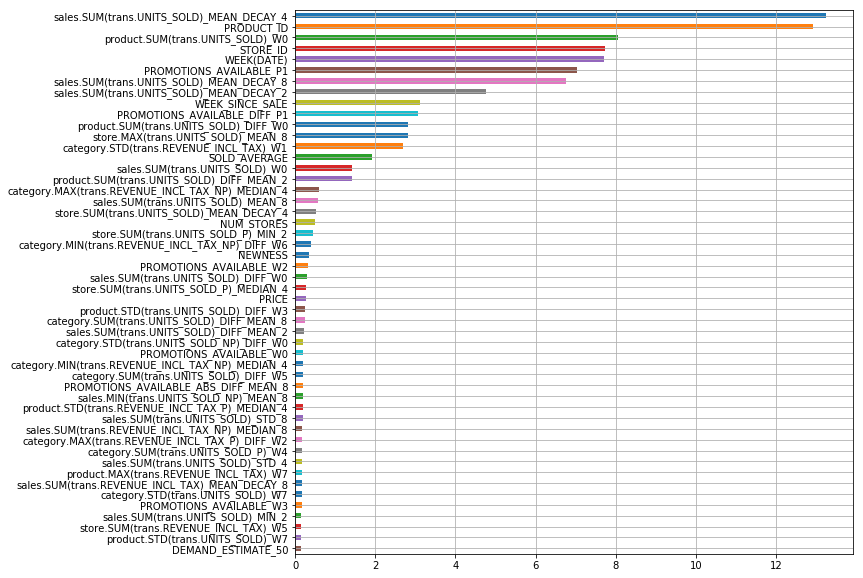

In [40]:
score.head(50).Score.plot.barh(grid=True, figsize=(10,10)).invert_yaxis()

In [41]:
fltr = pd.read_parquet('/main/data/MVideo_2/crosstest.parquet')

In [42]:
fltr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163122 entries, 3000 to 10833687
Data columns (total 3 columns):
STORE_ID      163122 non-null category
PRODUCT_ID    163122 non-null category
DATE          163122 non-null datetime64[ns]
dtypes: category(2), datetime64[ns](1)
memory usage: 3.1 MB


In [43]:
data_test2 = pd.merge(data_test, fltr, how = 'inner')

In [44]:
data_test2[['PRODUCT_ID', 'MAINCATEGORY_ID', 'SUBCATEGORY_ID',
       'STORE_ID', 'REGION', 'INTERNET',
       'WEEK(DATE)', 'MONTH(DATE)']] = data_test2[['PRODUCT_ID', 'MAINCATEGORY_ID', 'SUBCATEGORY_ID',
                                                          'STORE_ID', 'REGION', 'INTERNET',
                                                          'WEEK(DATE)', 'MONTH(DATE)']].astype('category')

In [45]:
pred3 = bst2.predict(data_test2[feat])

In [46]:
np.sqrt(mean_squared_error(data_test2.UNITS_SOLD_P1, pred3))

0.7316327720393592

In [47]:
mean_absolute_error(data_test2.UNITS_SOLD_P1, pred3)

0.4472566651088584

In [48]:
res3 = data_test2[['DATE', 'PRODUCT_ID', 'STORE_ID', 'UNITS_SOLD_P1']].copy()

In [49]:
res3['PRED_P1'] = pred3

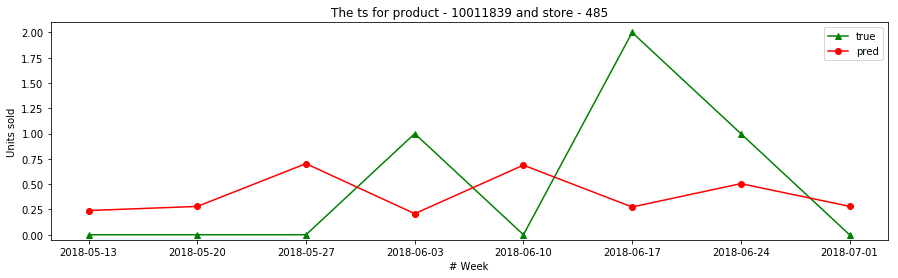

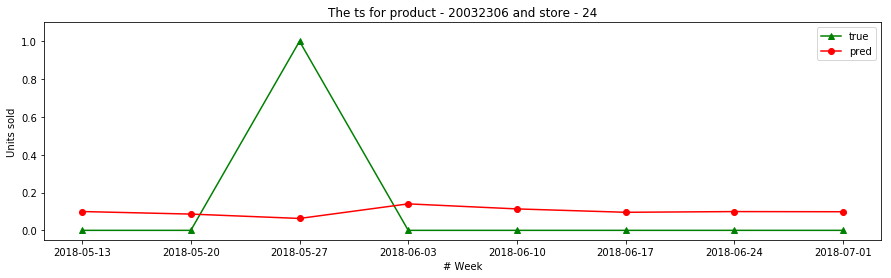

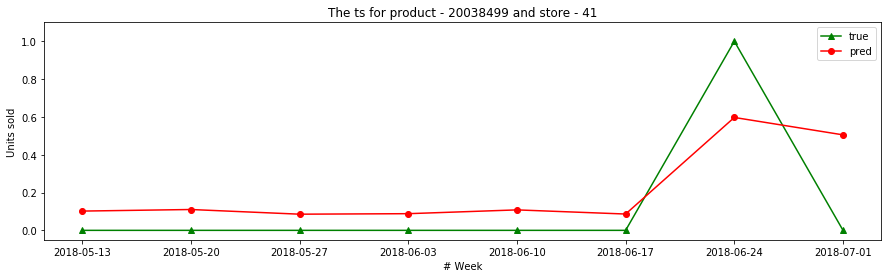

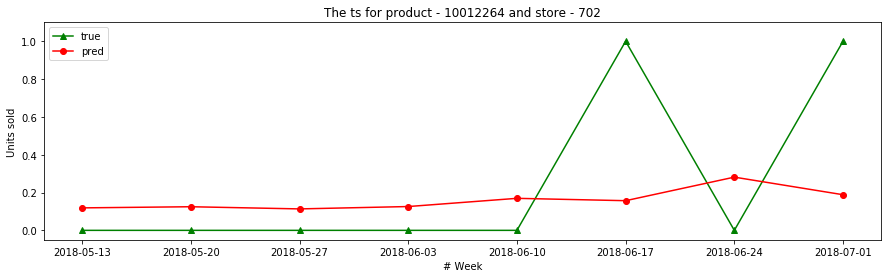

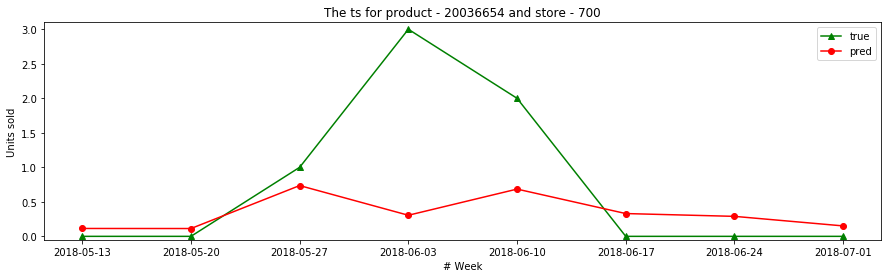

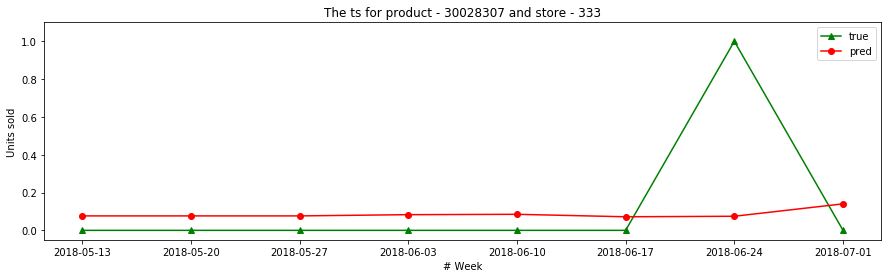

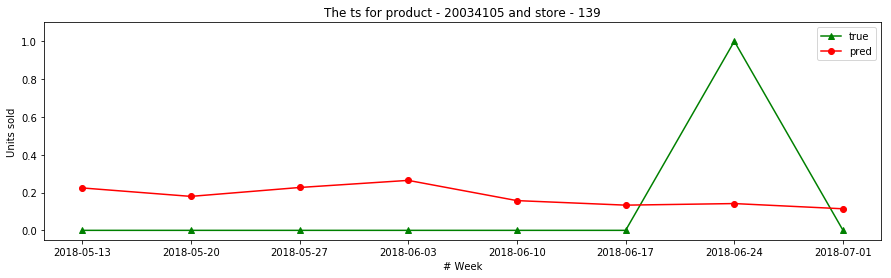

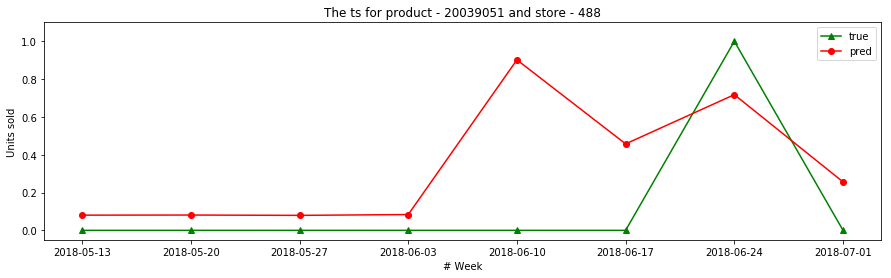

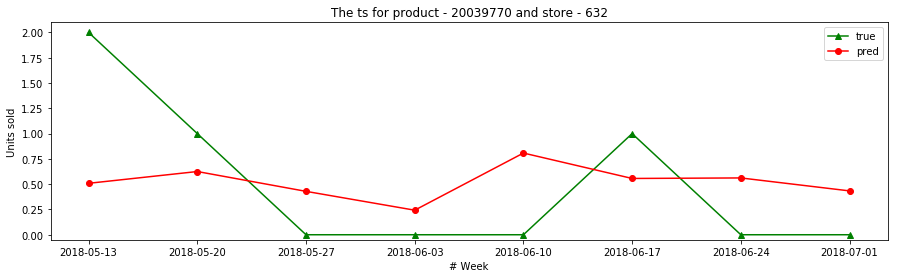

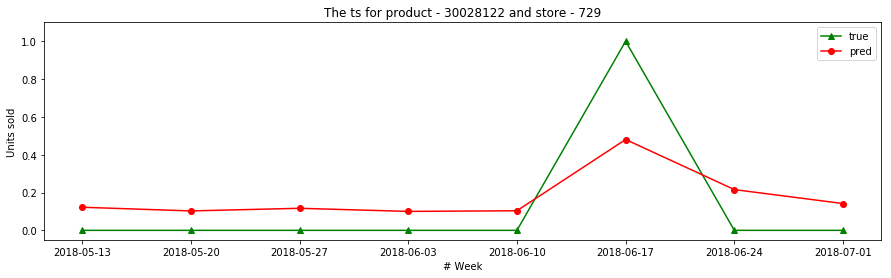

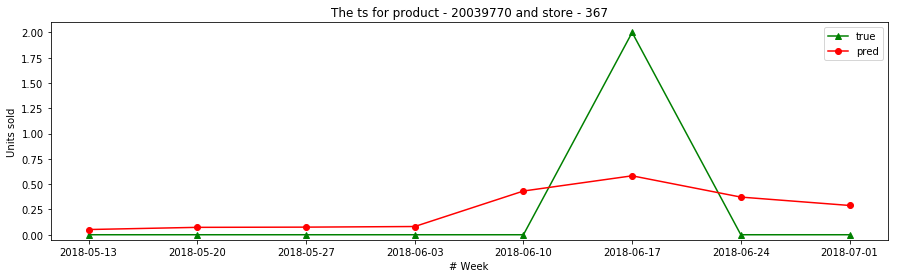

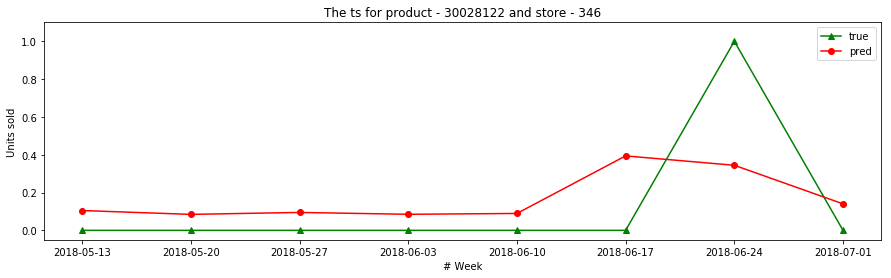

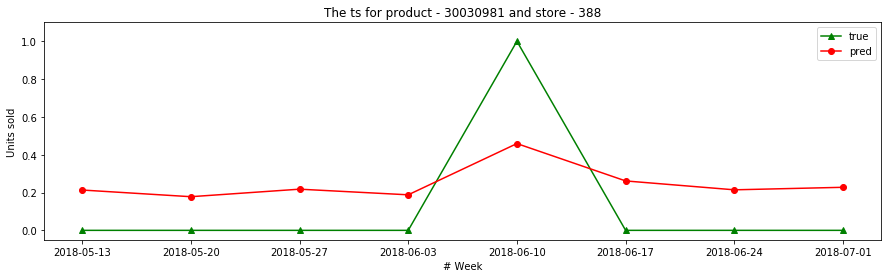

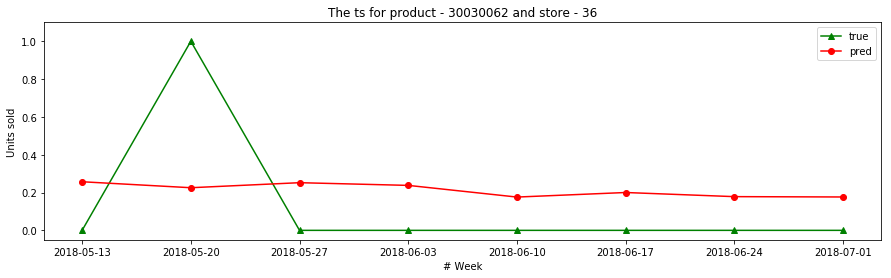

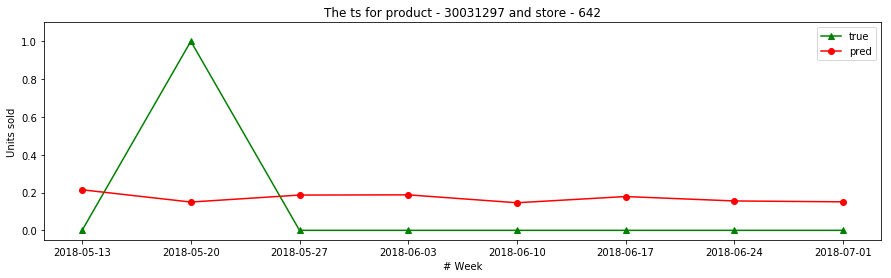

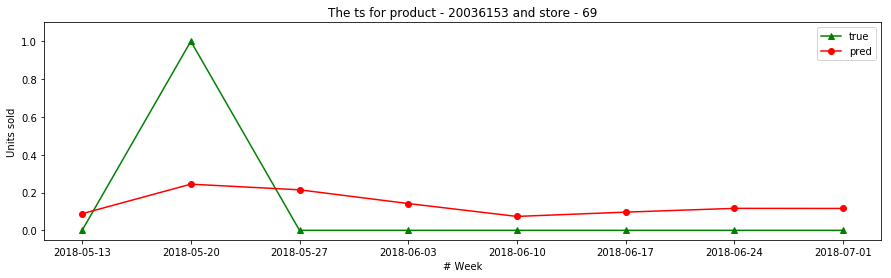

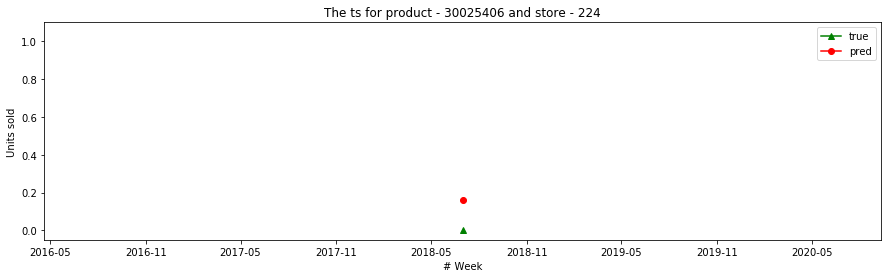

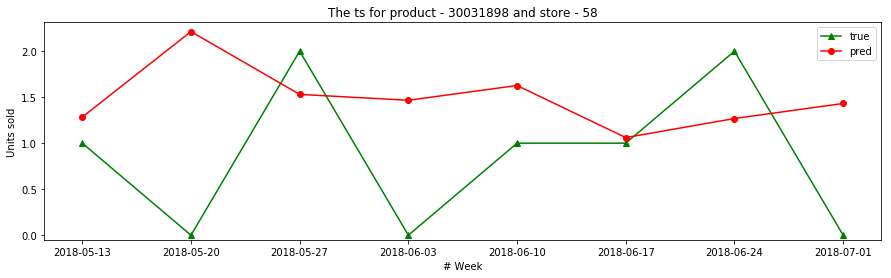

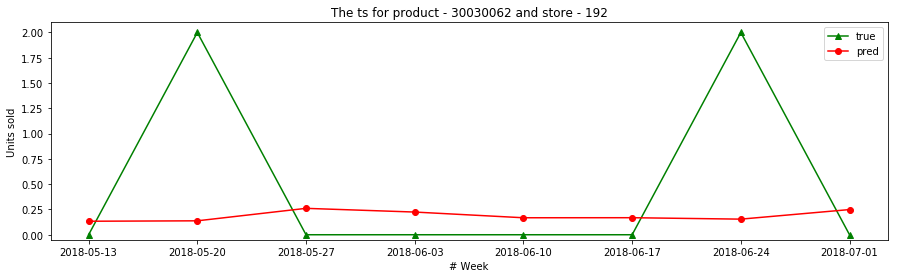

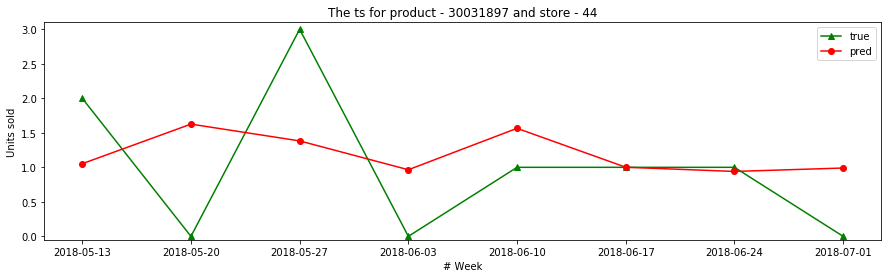

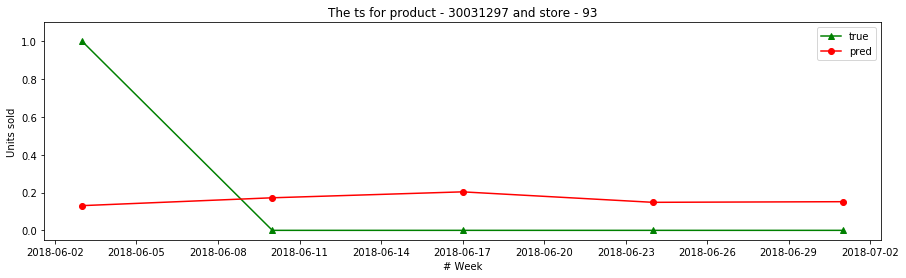

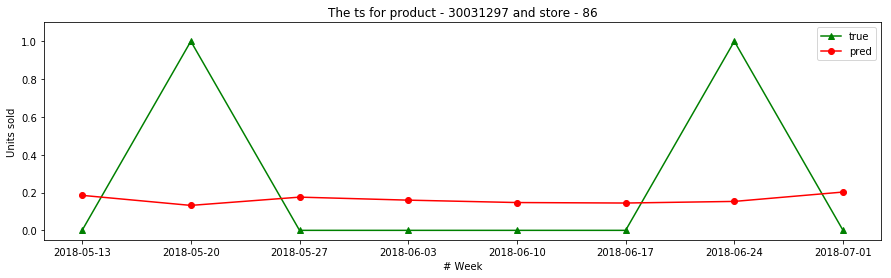

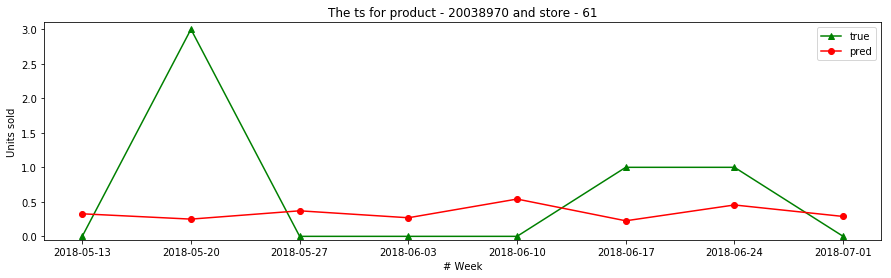

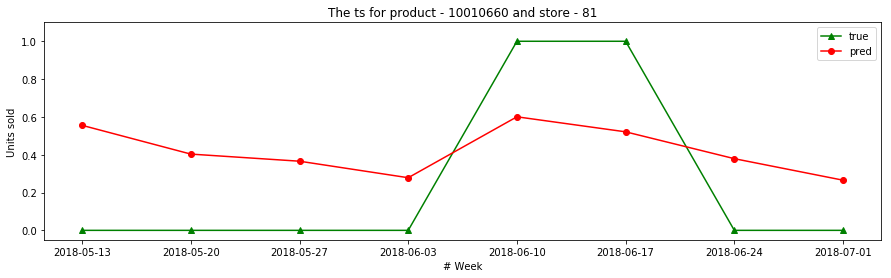

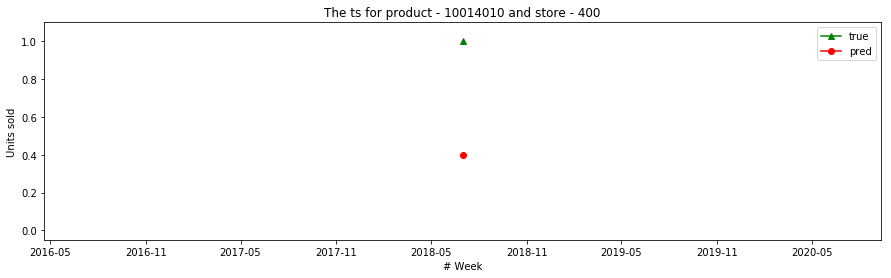

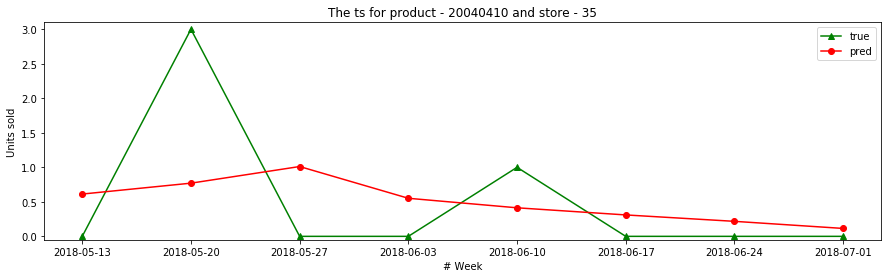

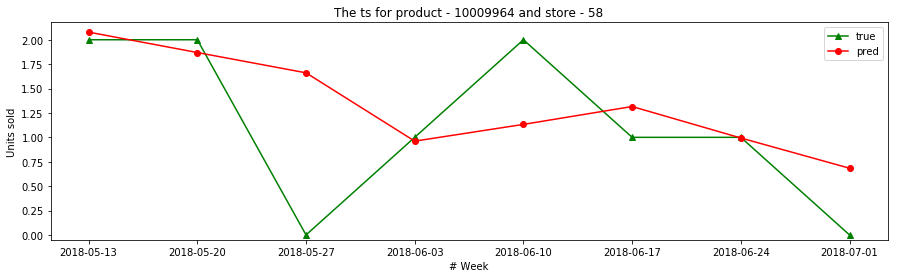

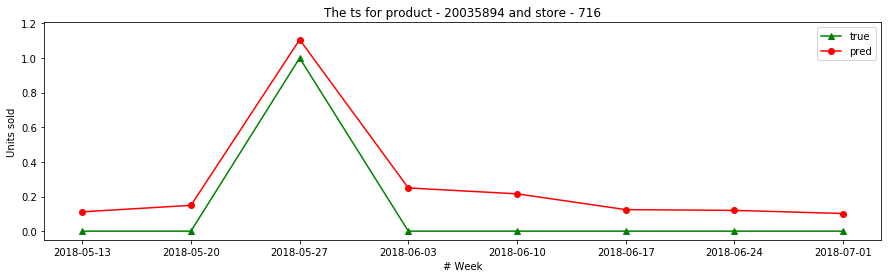

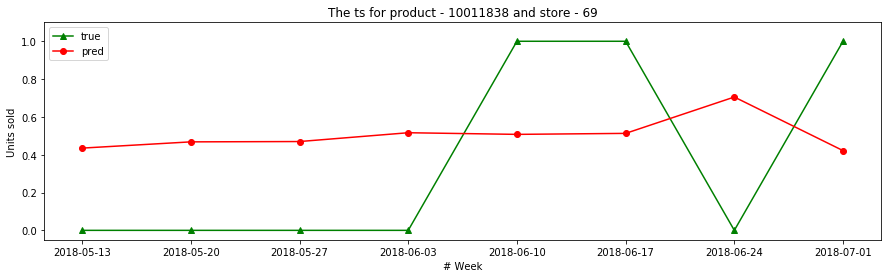

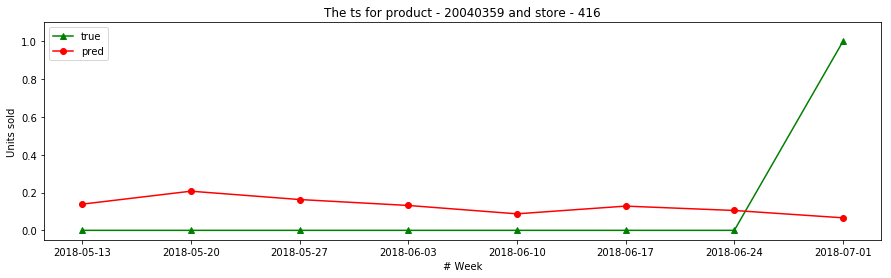

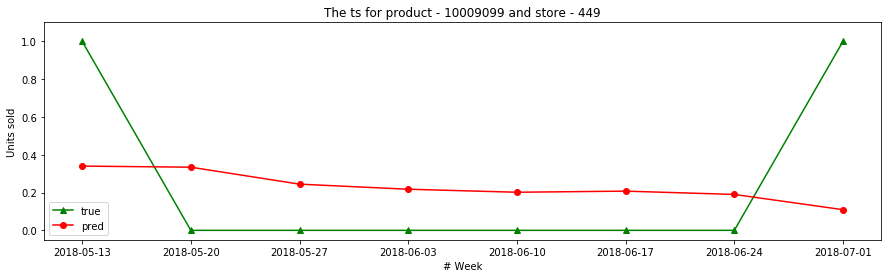

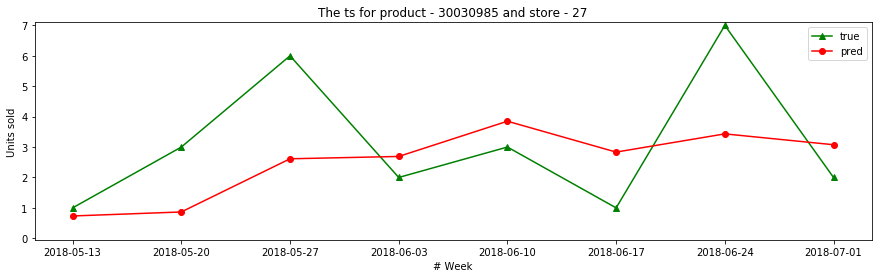

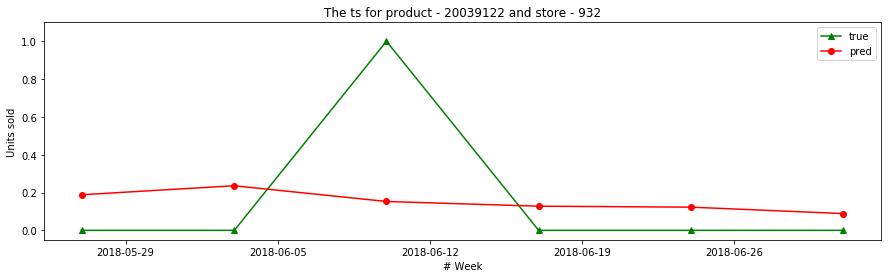

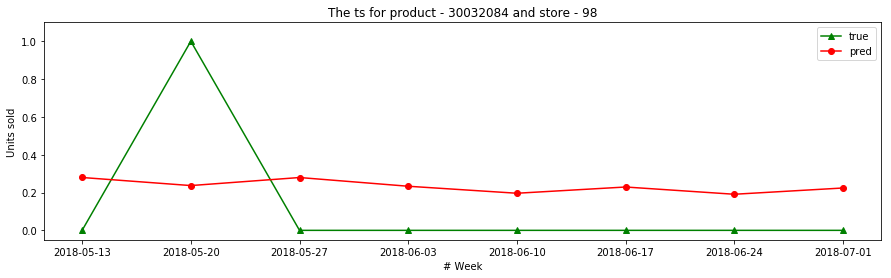

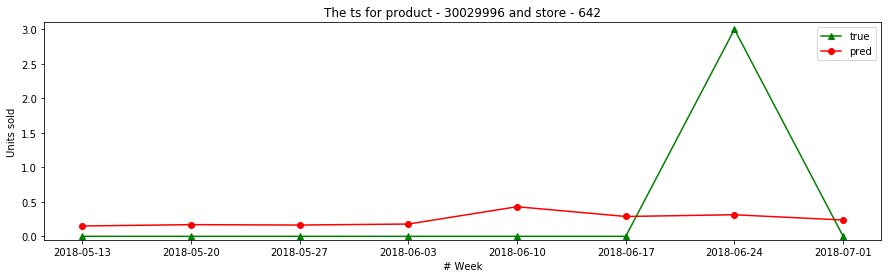

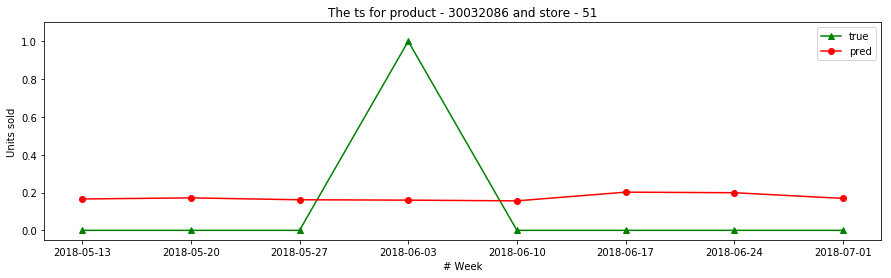

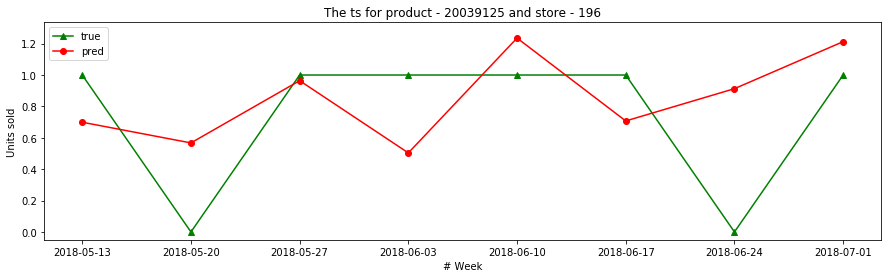

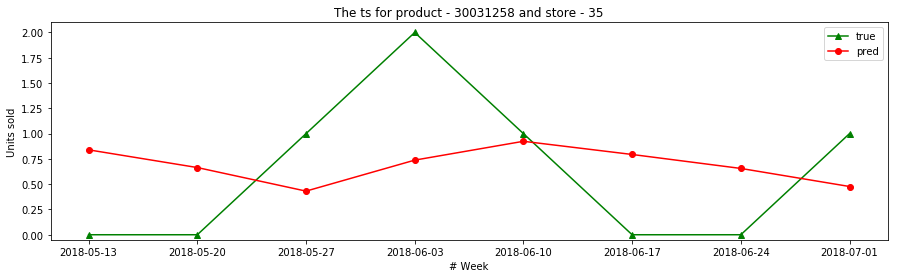

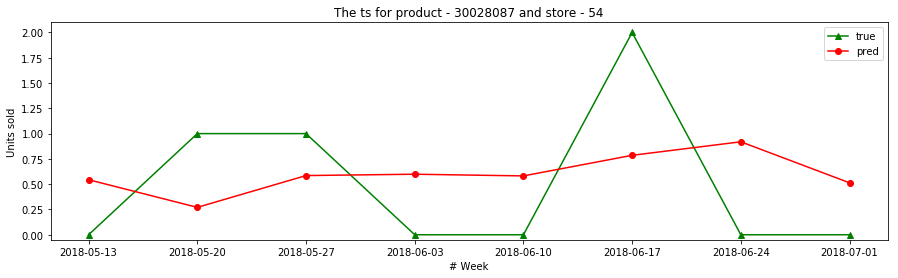

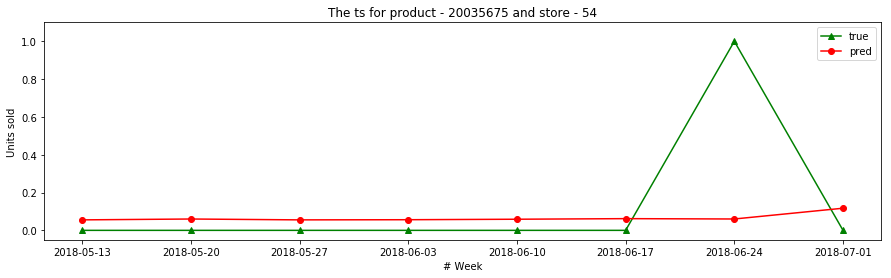

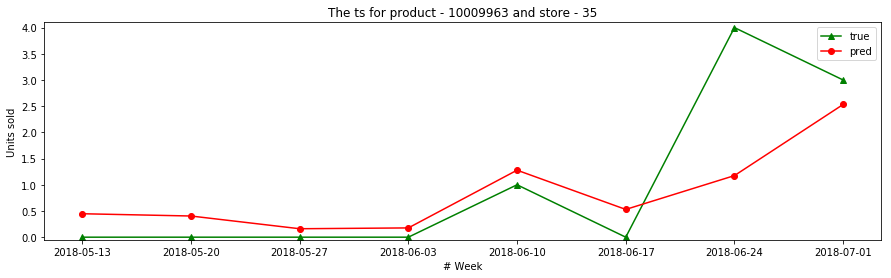

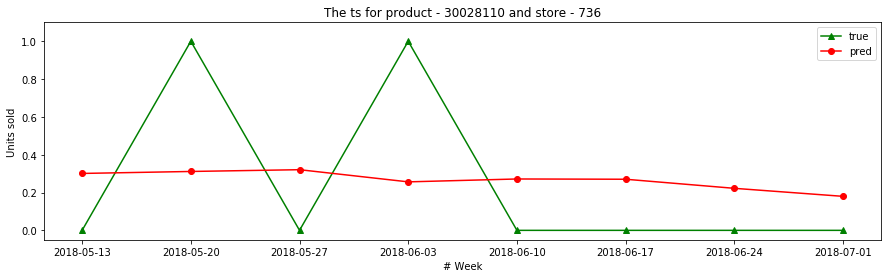

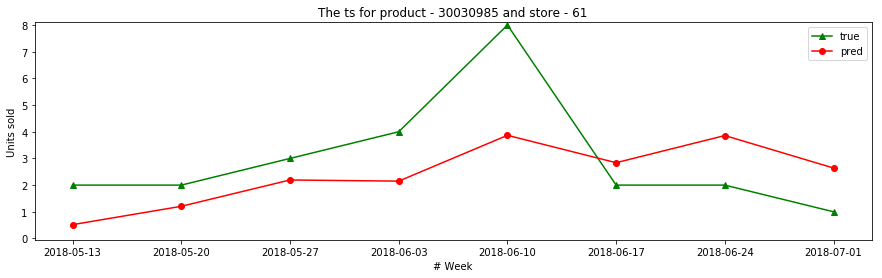

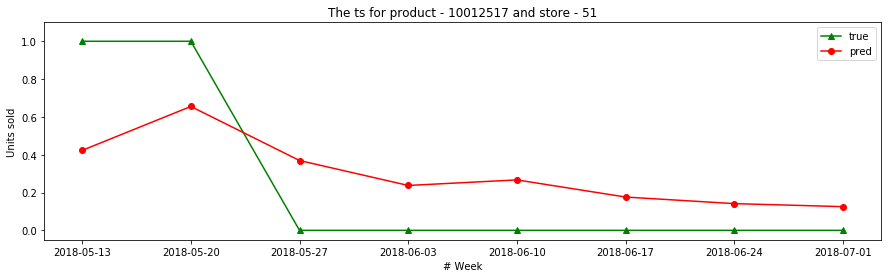

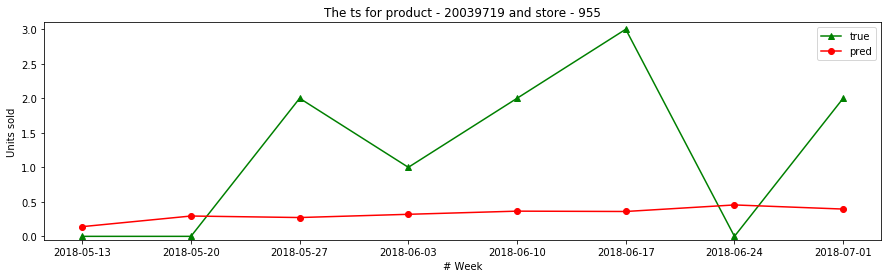

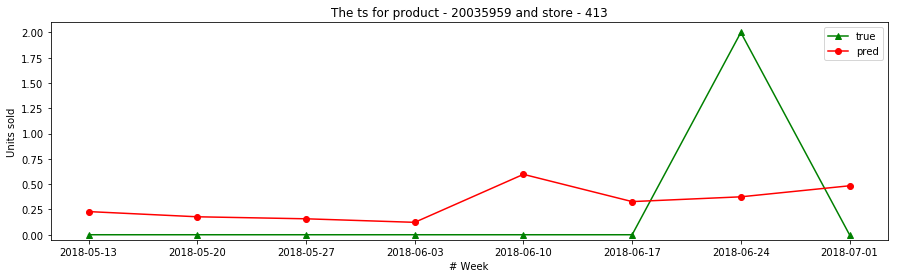

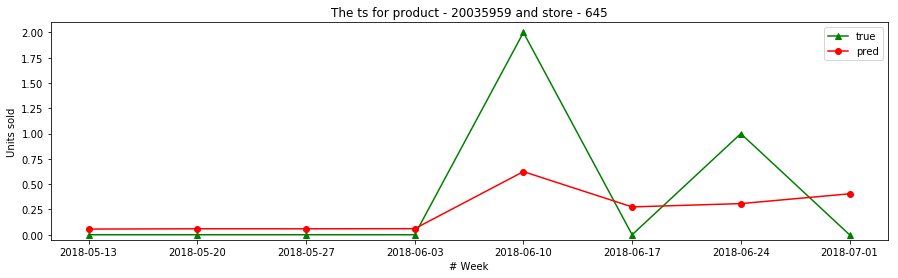

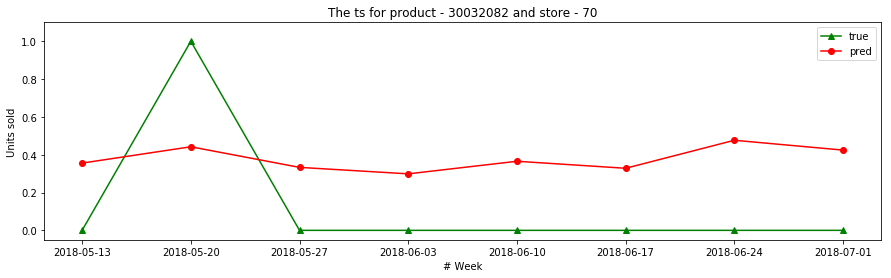

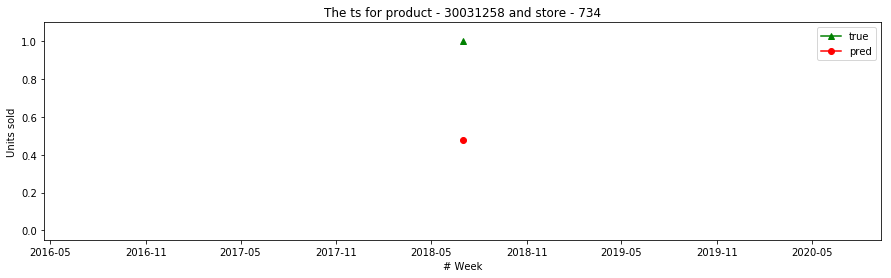

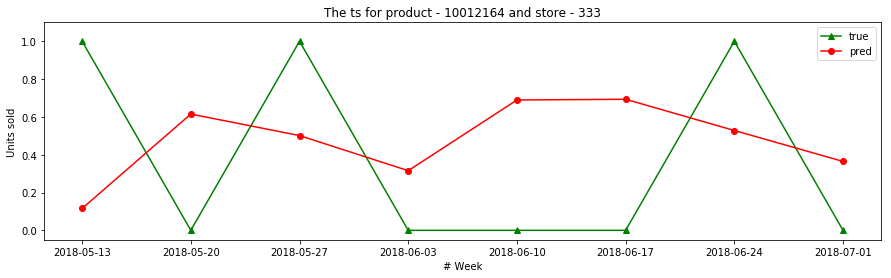

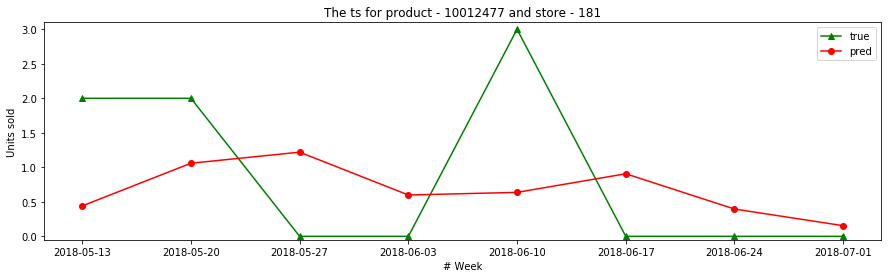

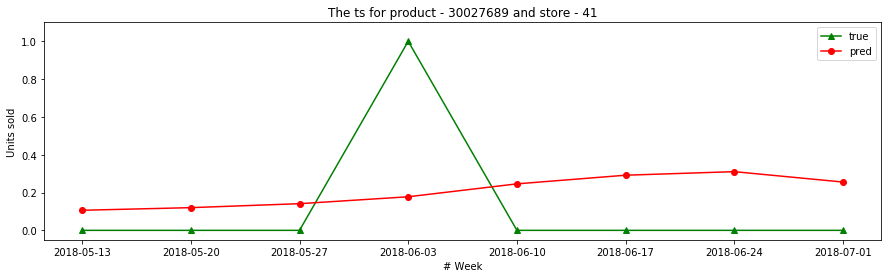

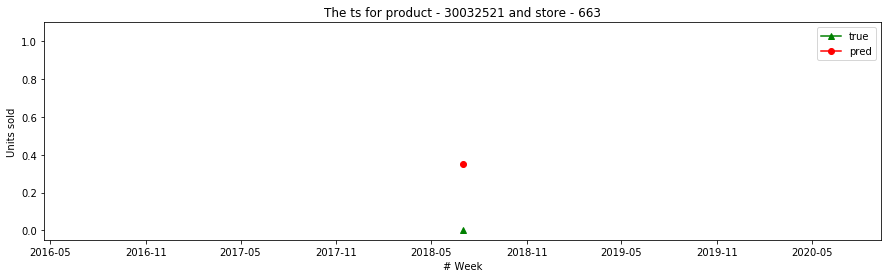

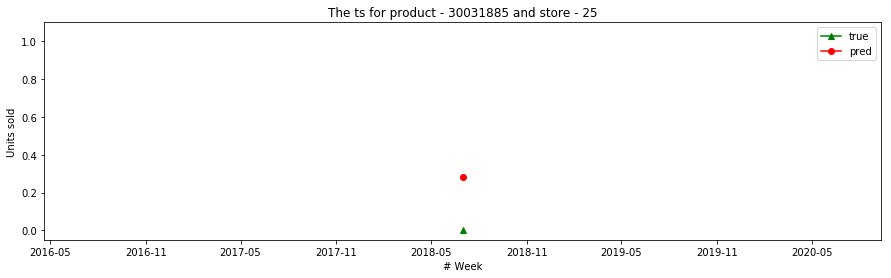

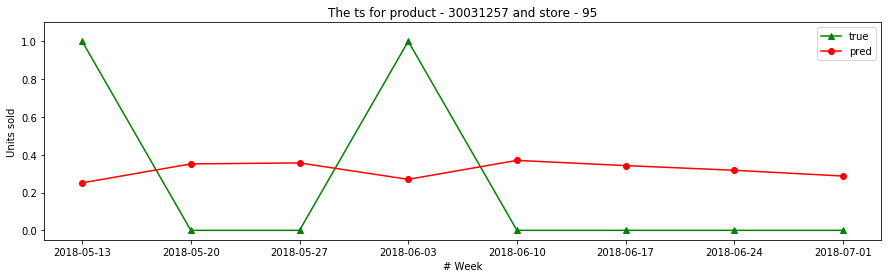

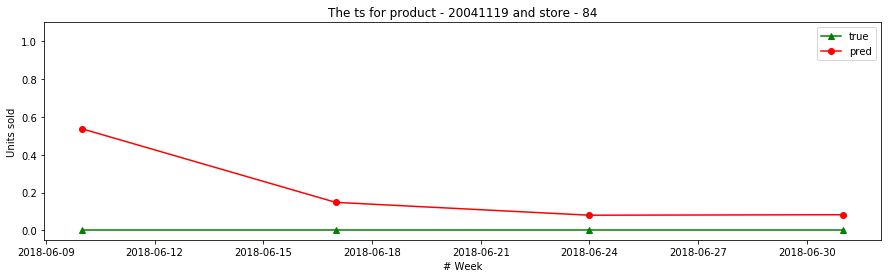

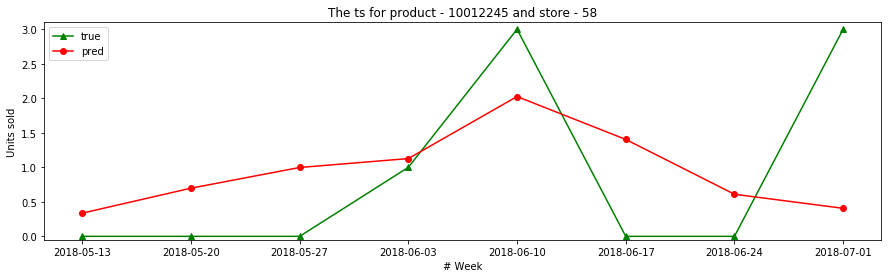

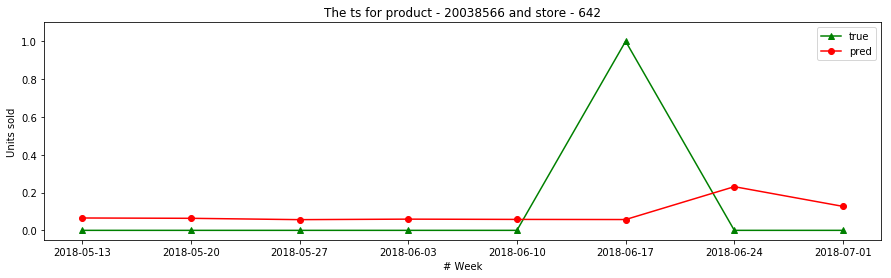

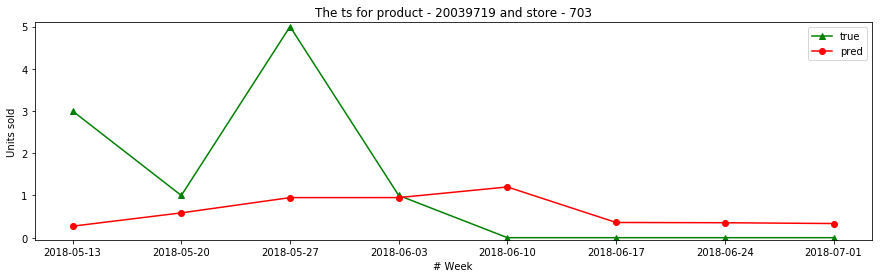

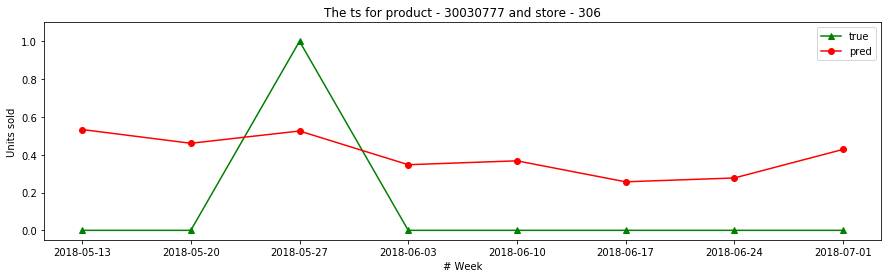

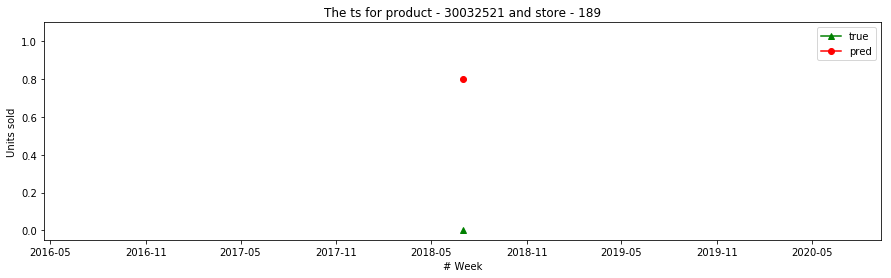

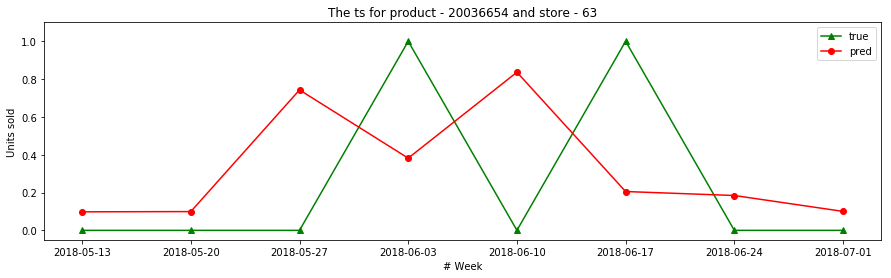

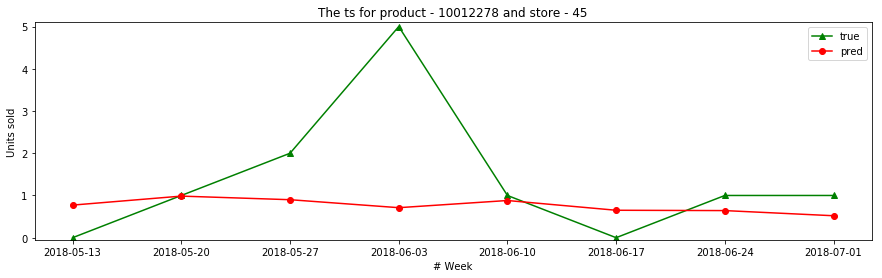

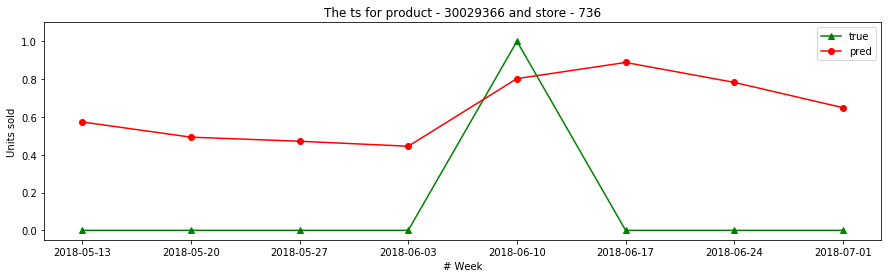

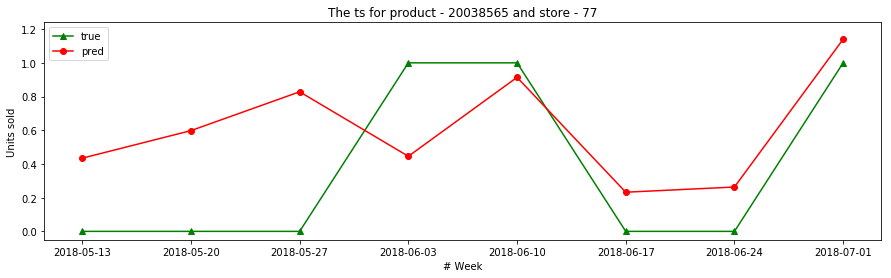

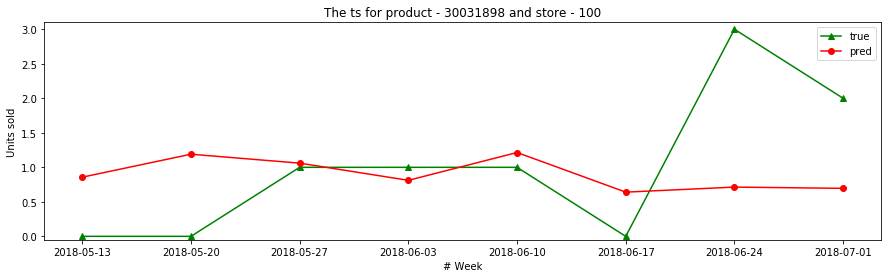

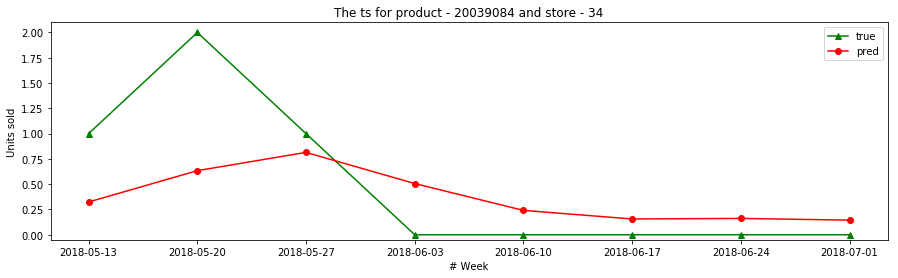

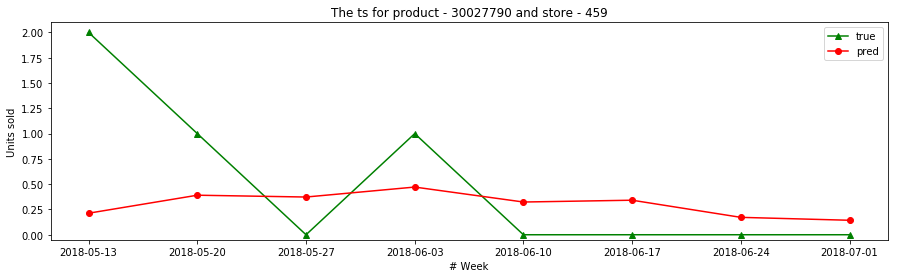

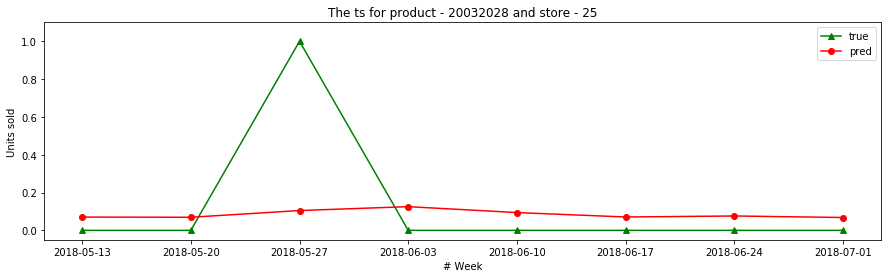

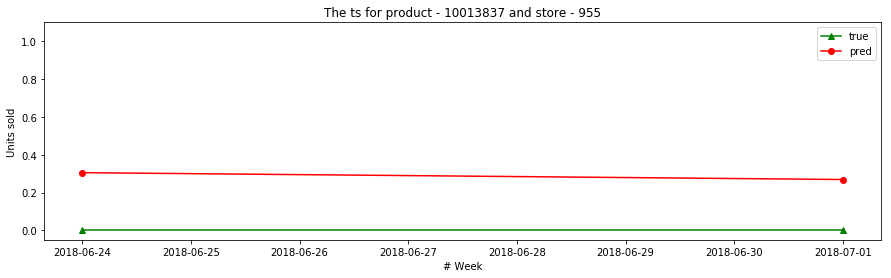

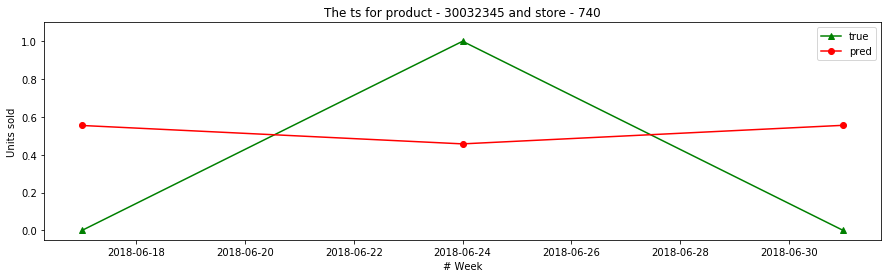

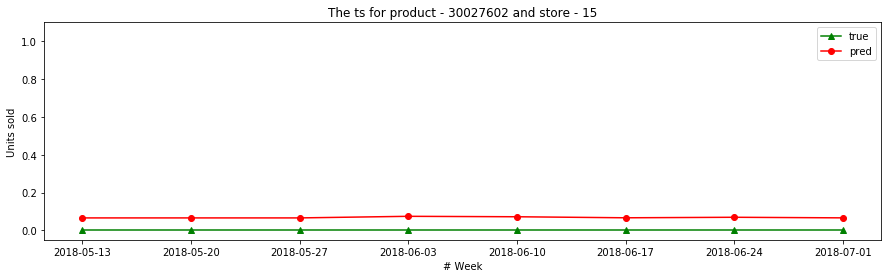

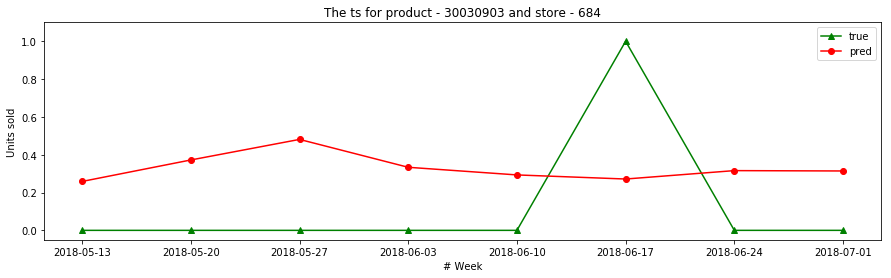

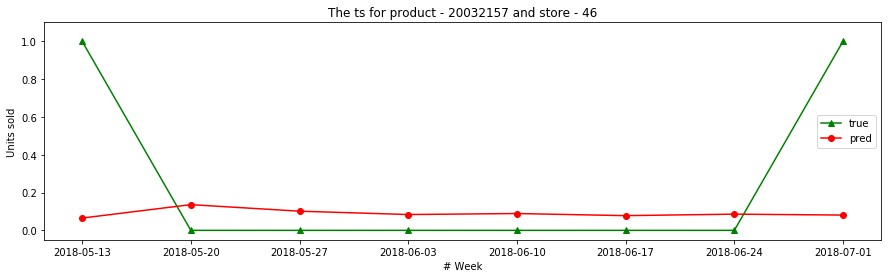

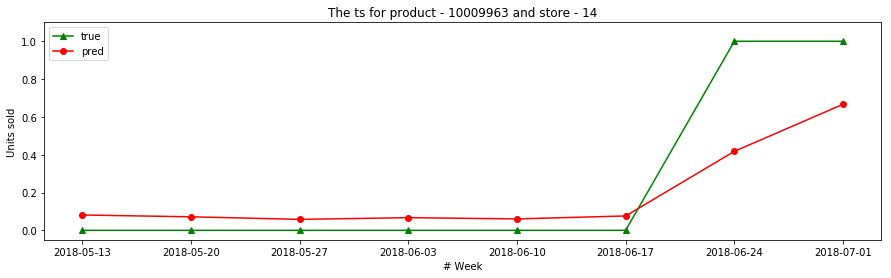

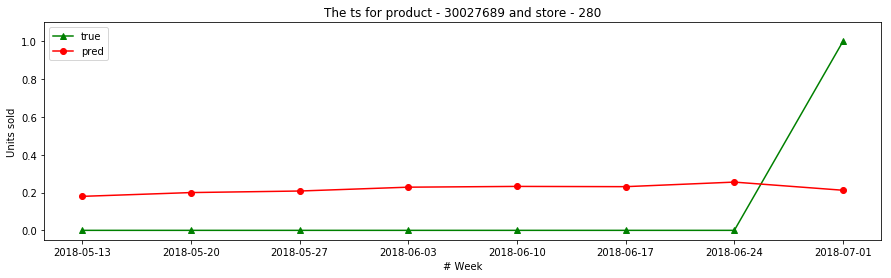

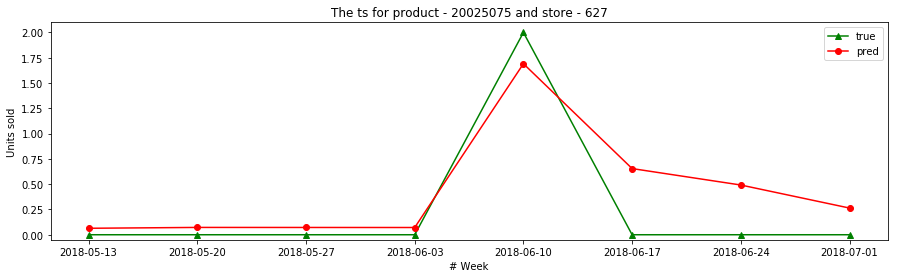

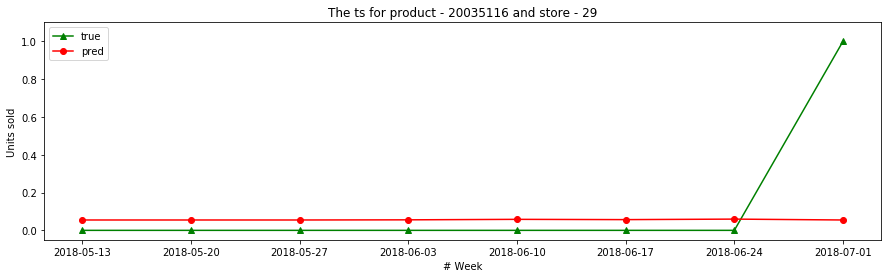

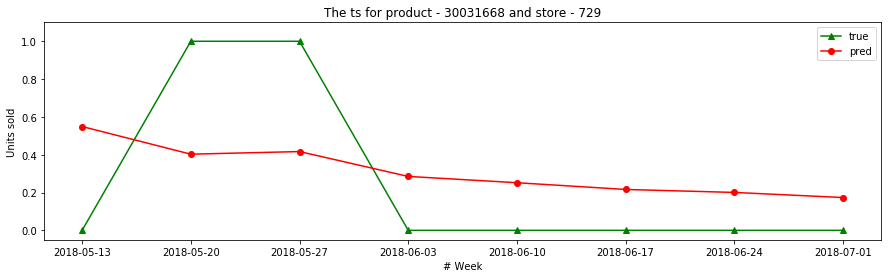

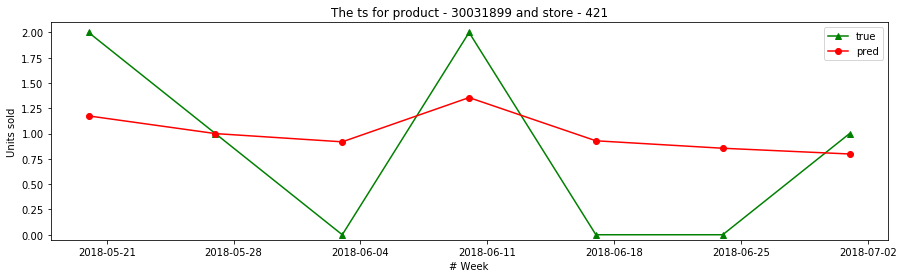

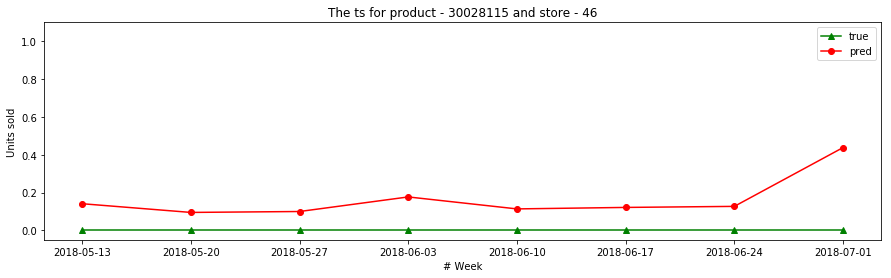

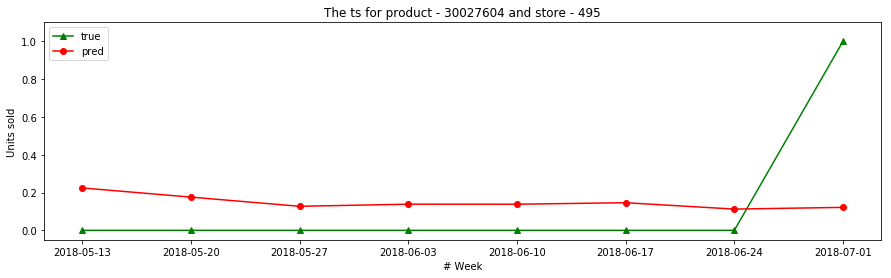

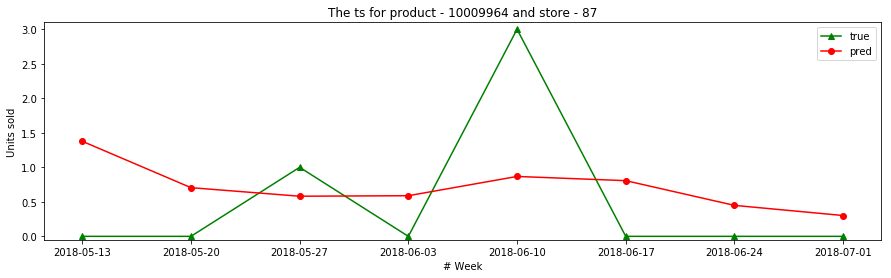

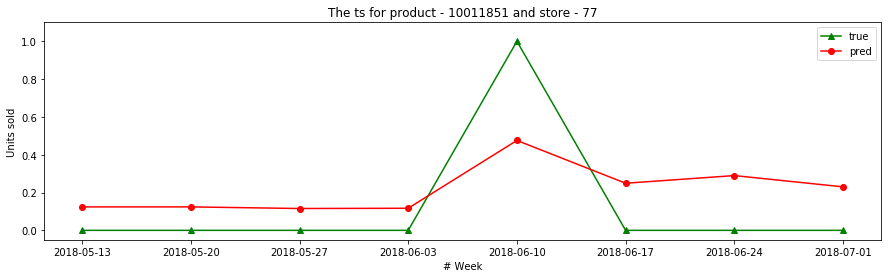

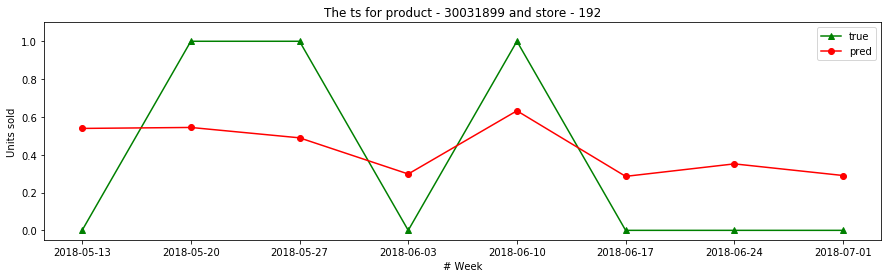

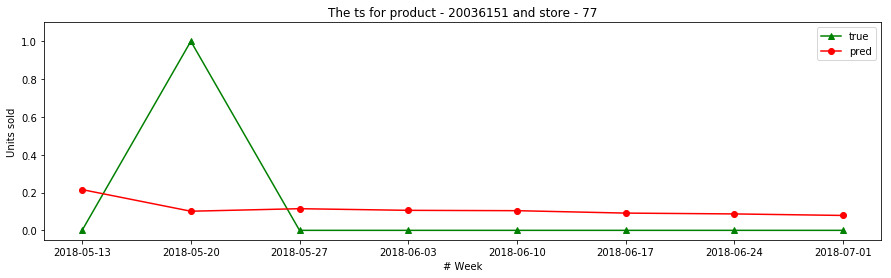

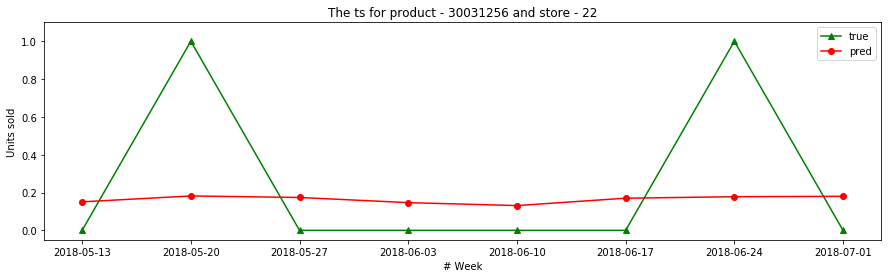

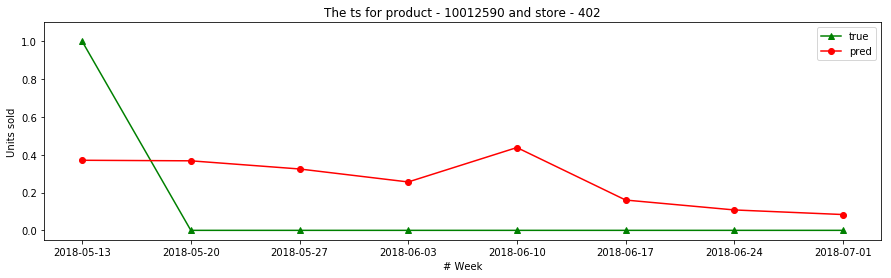

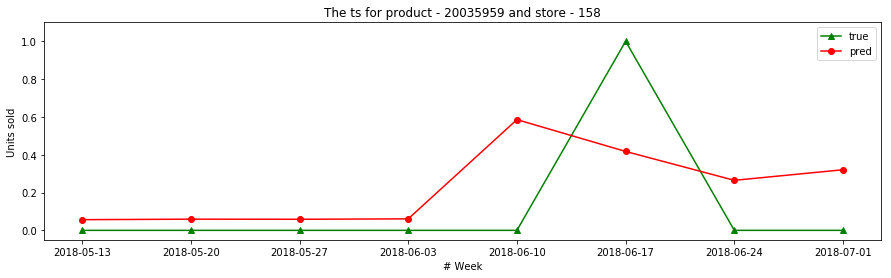

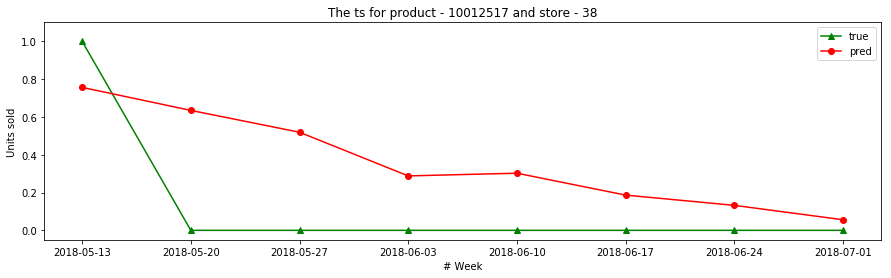

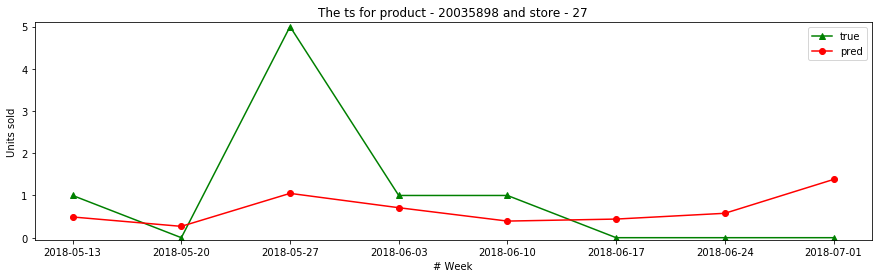

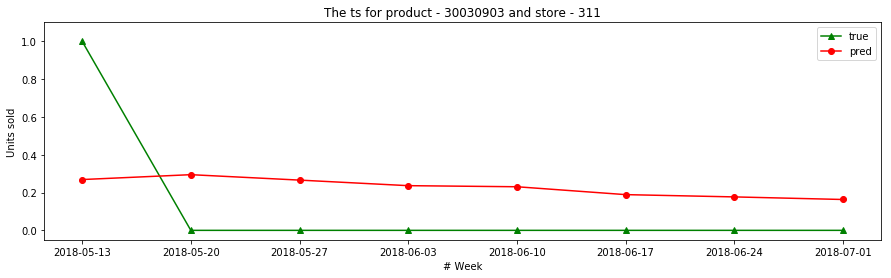

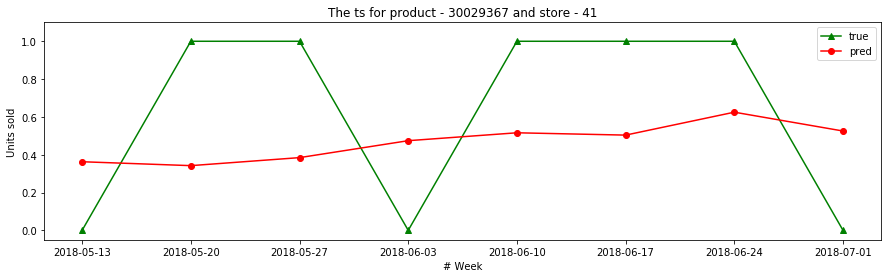

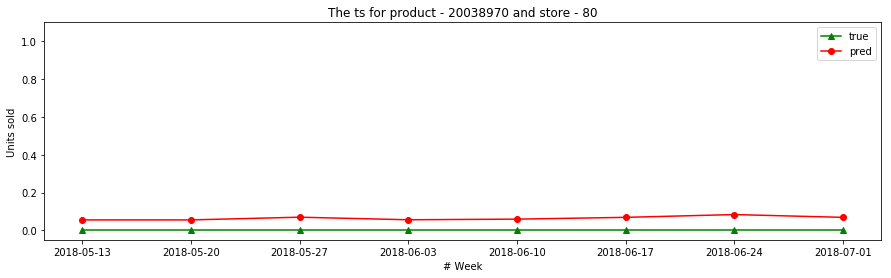

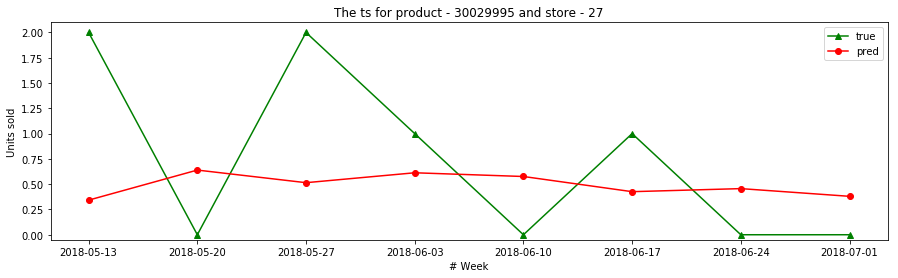

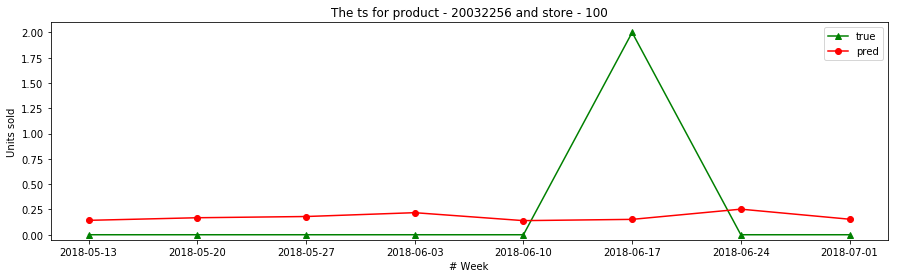

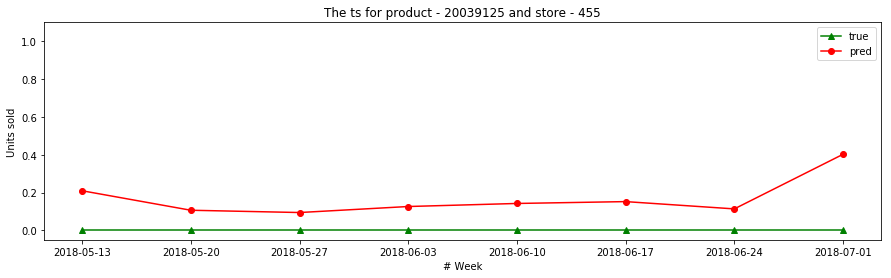

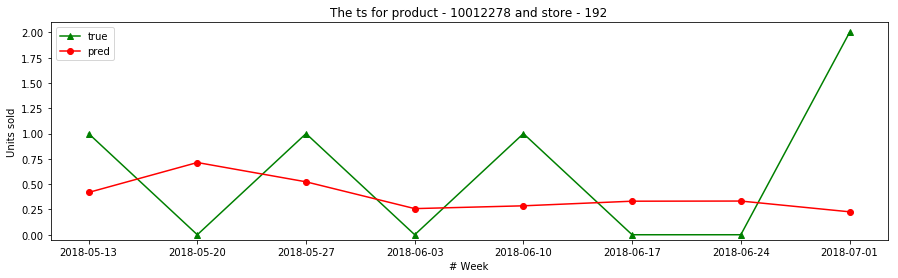

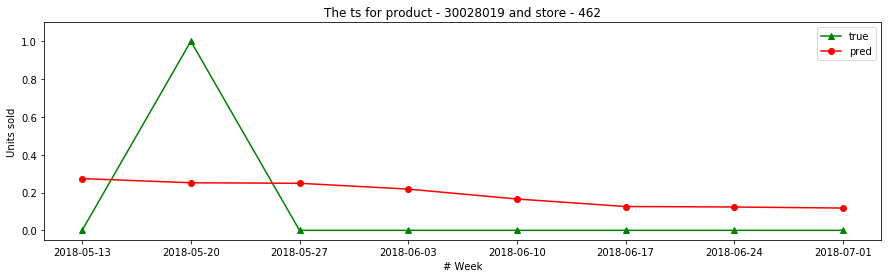

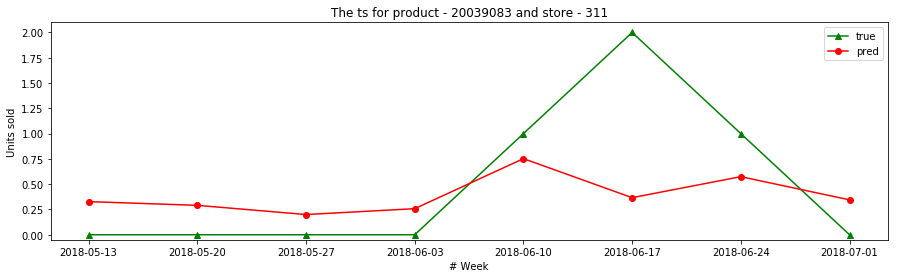

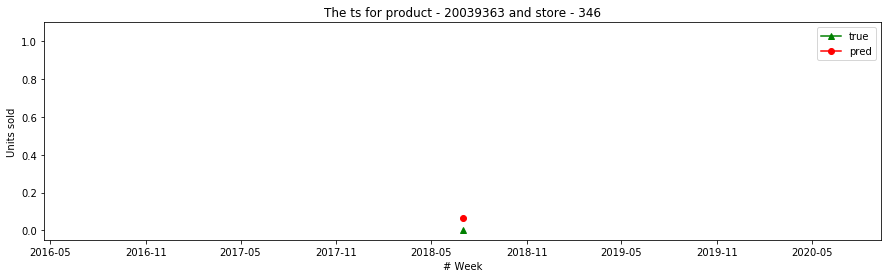

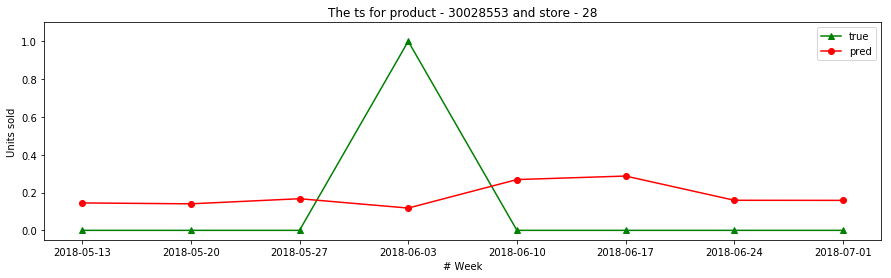

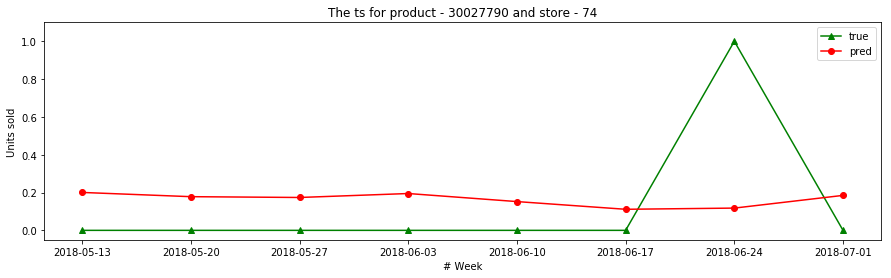

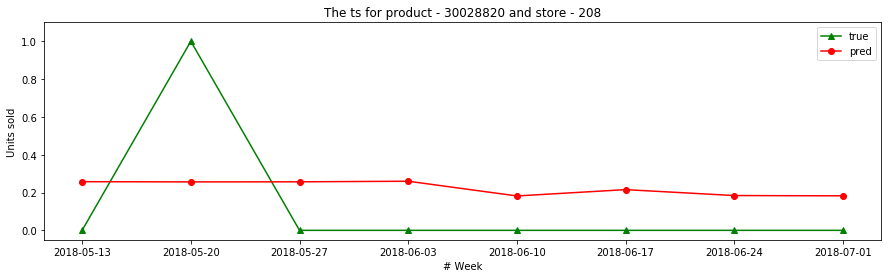

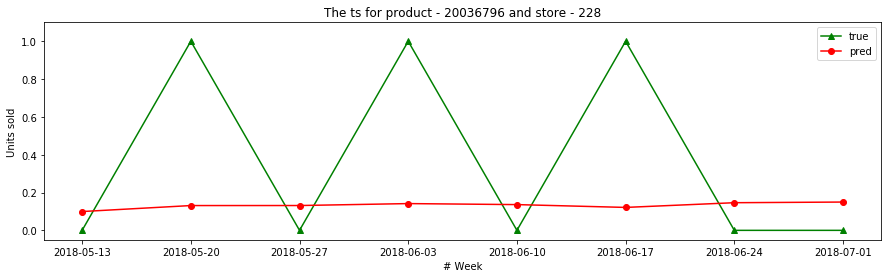

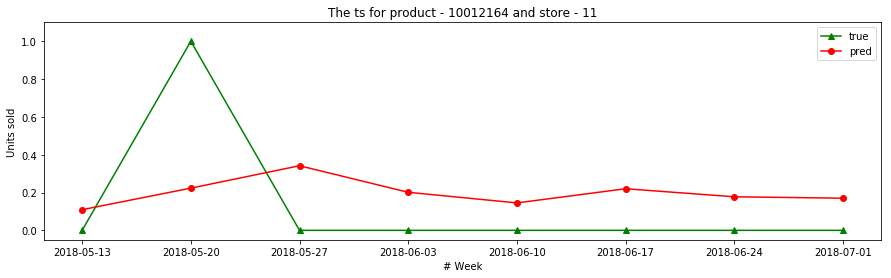

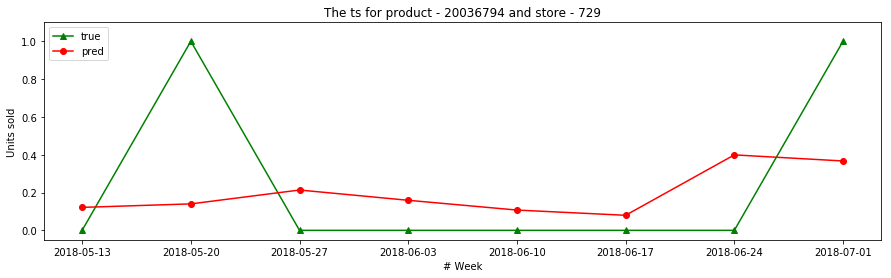

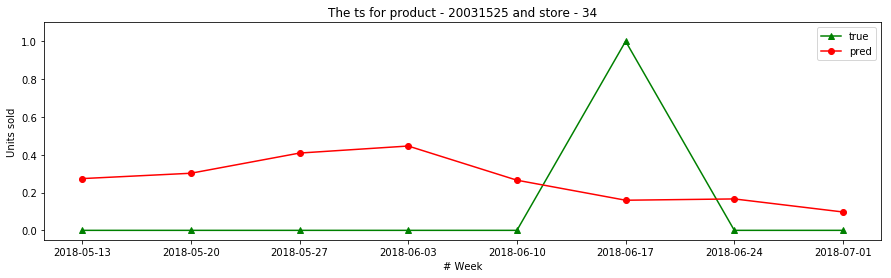

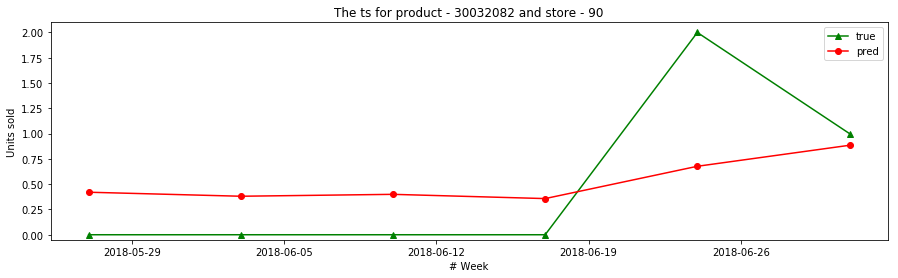

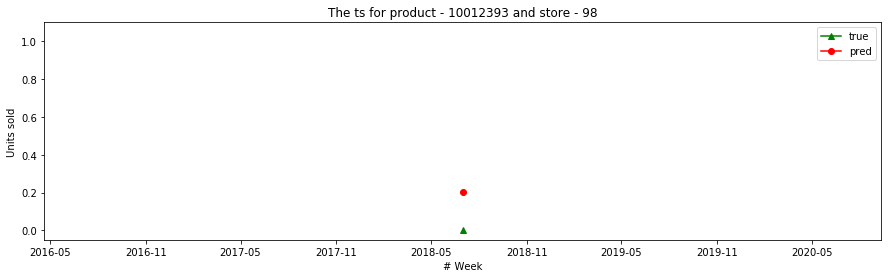

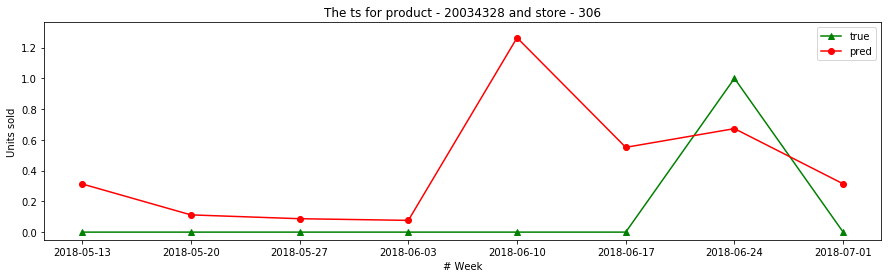

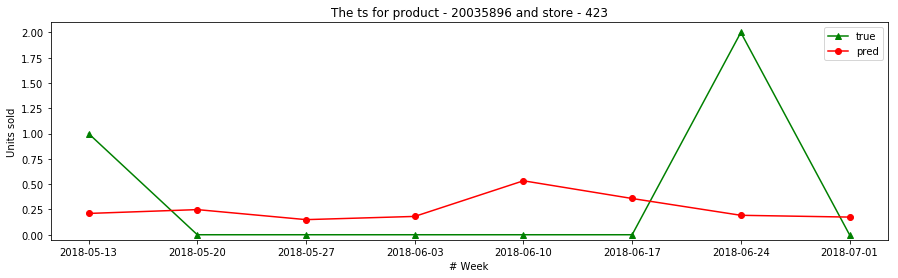

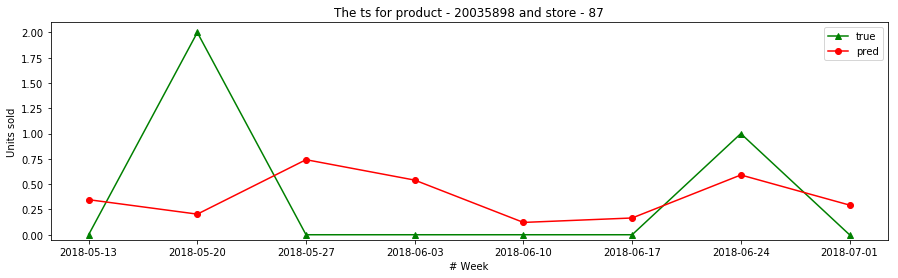

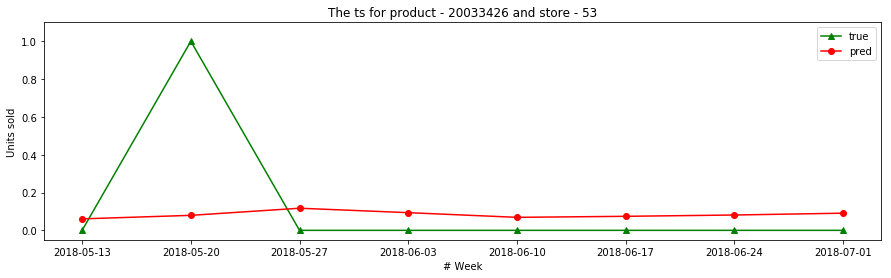

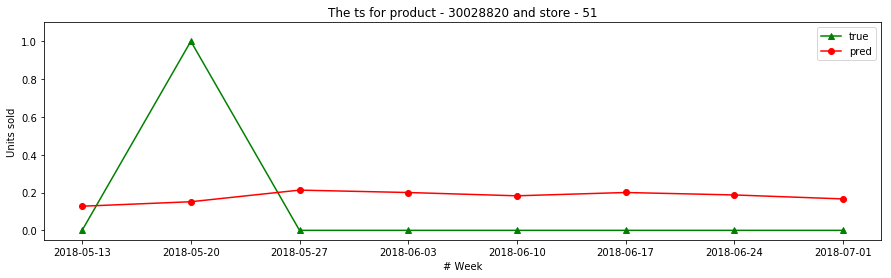

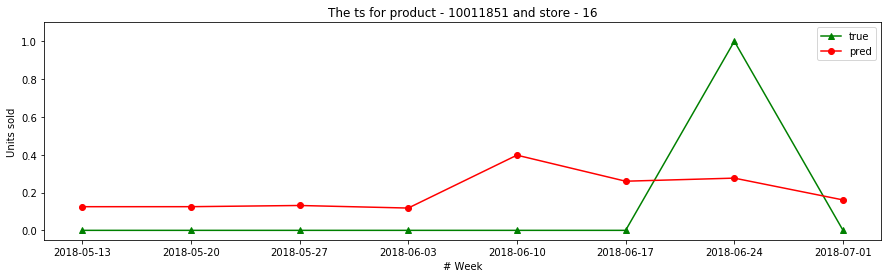

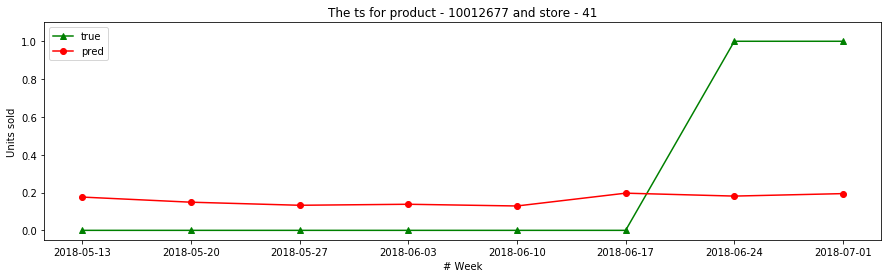

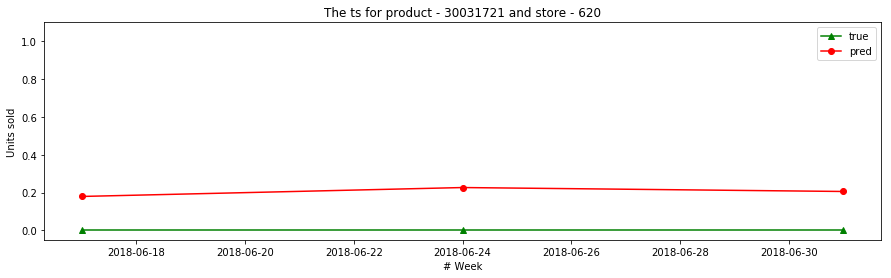

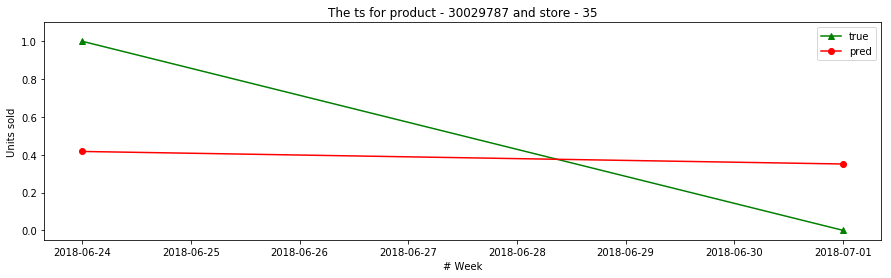

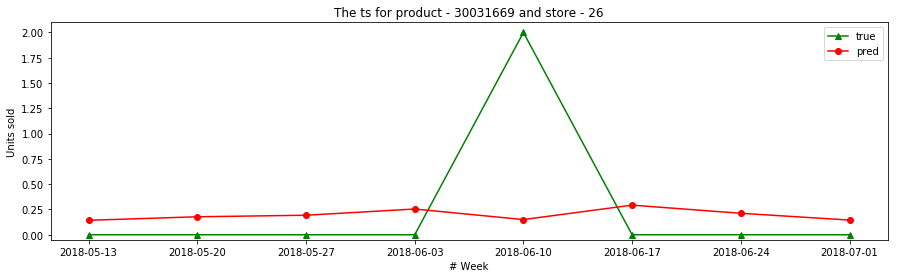

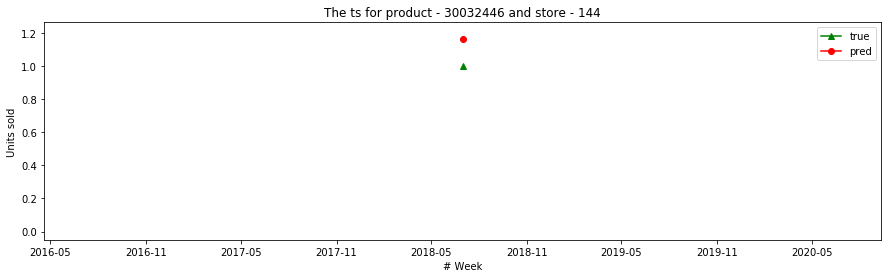

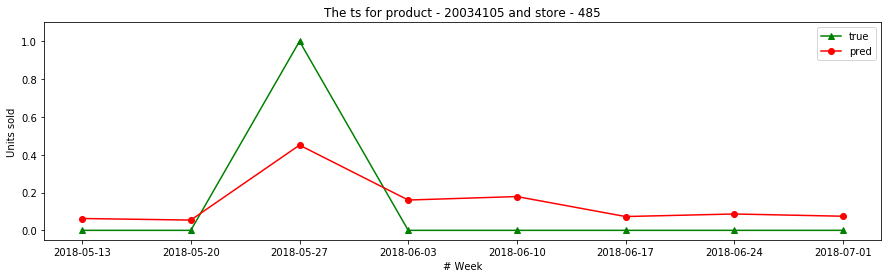

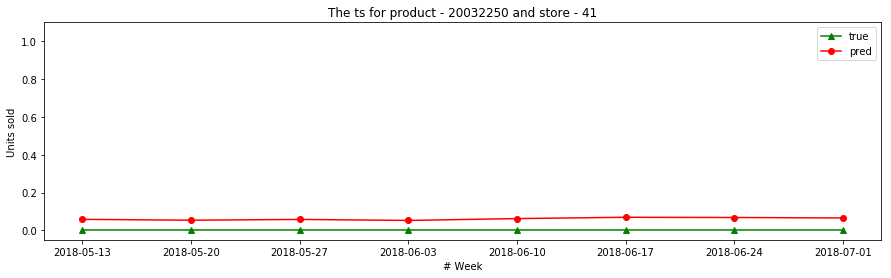

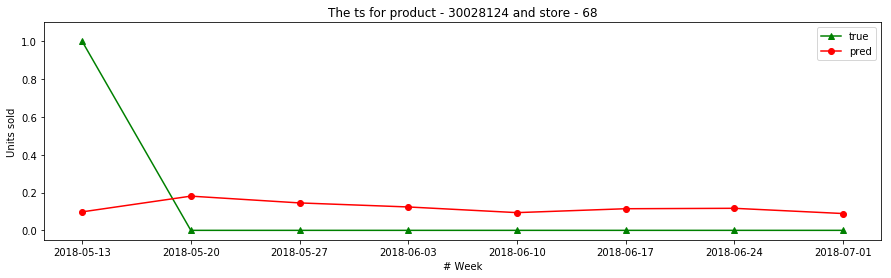

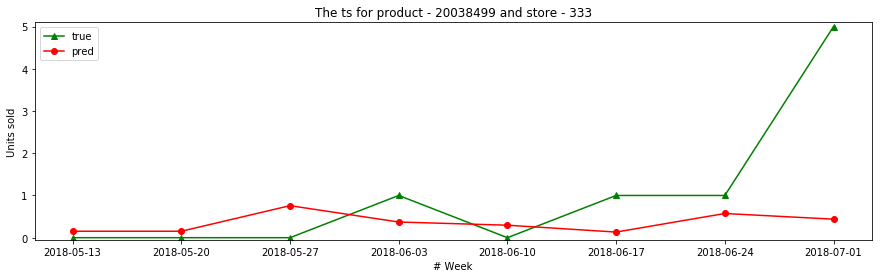

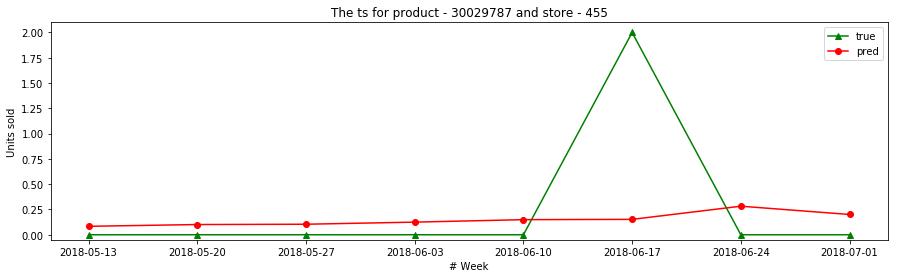

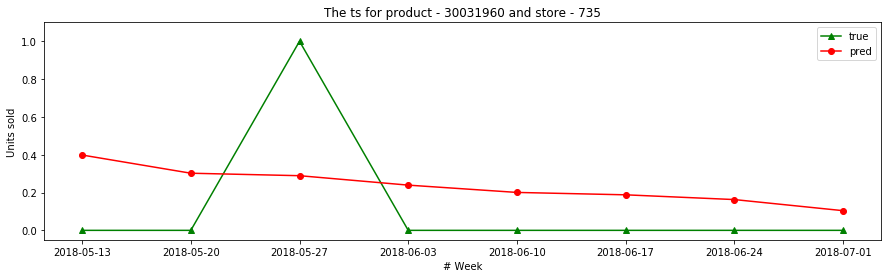

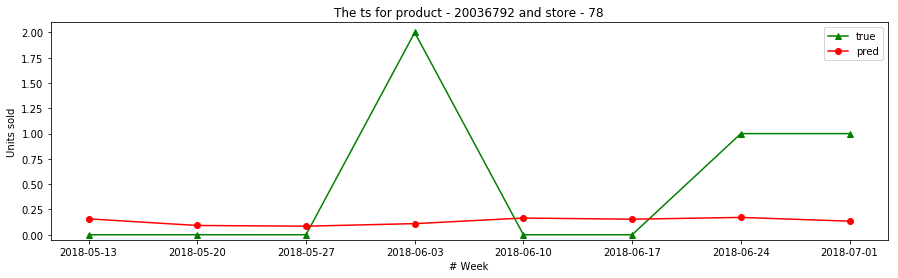

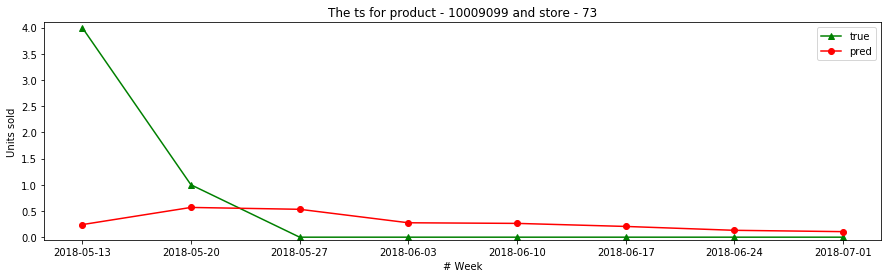

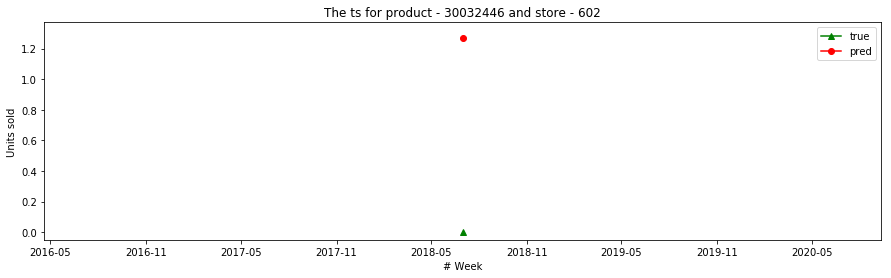

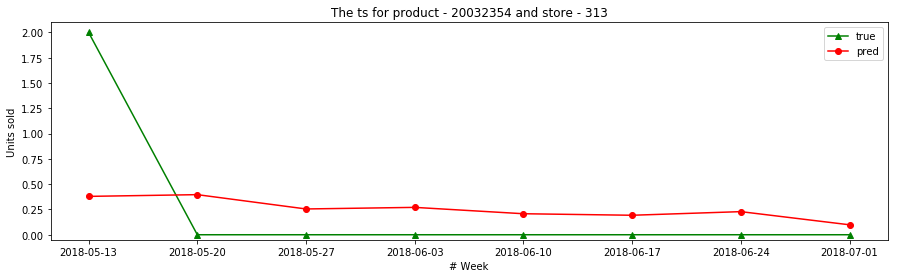

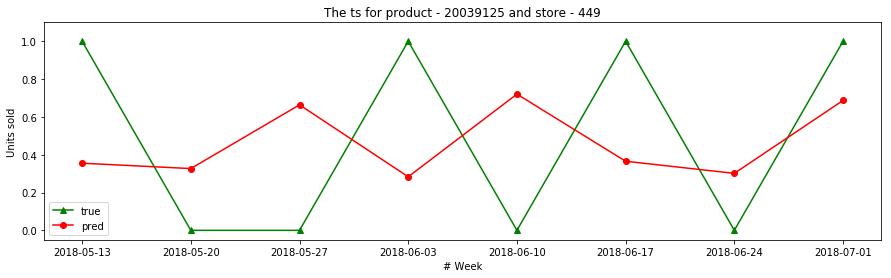

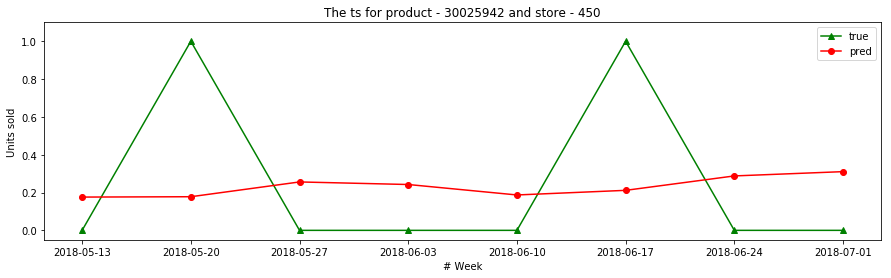

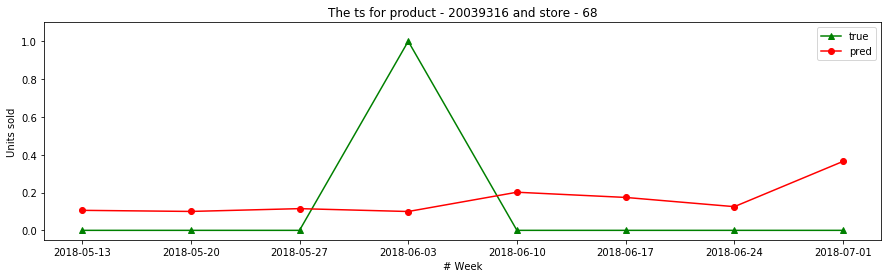

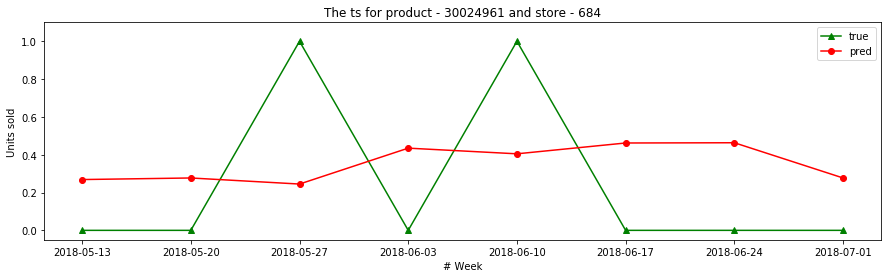

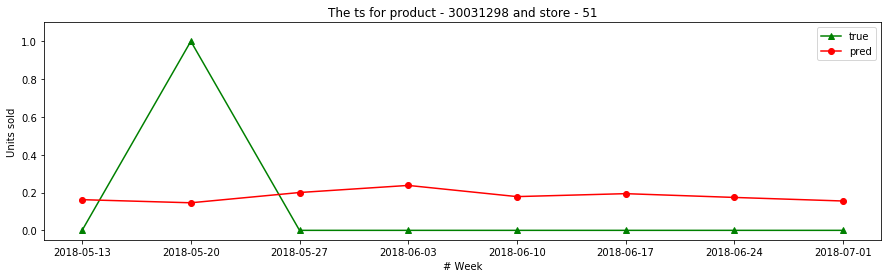

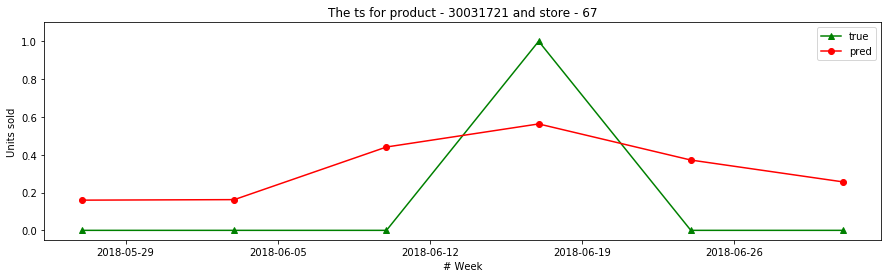

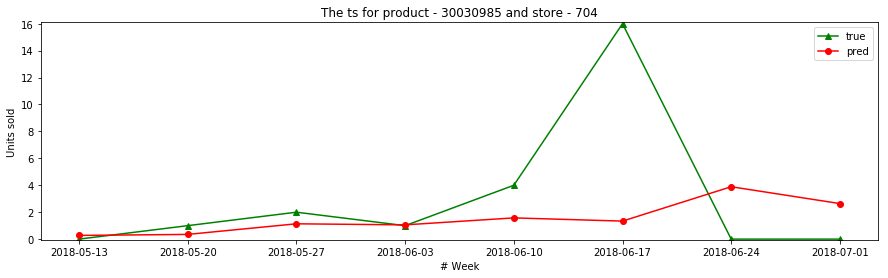

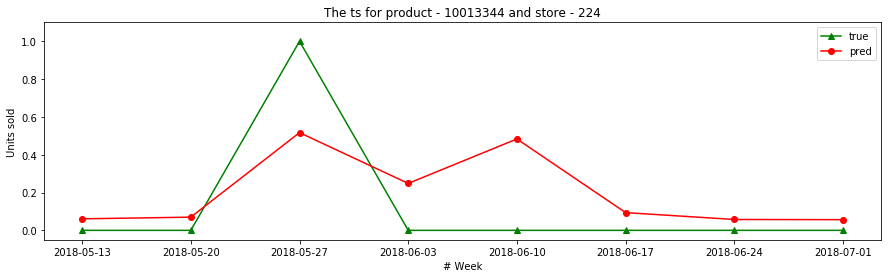

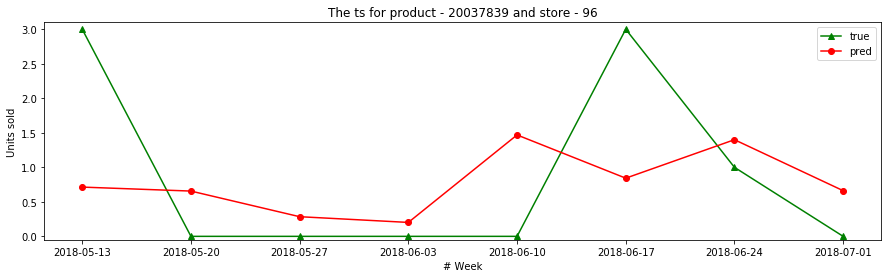

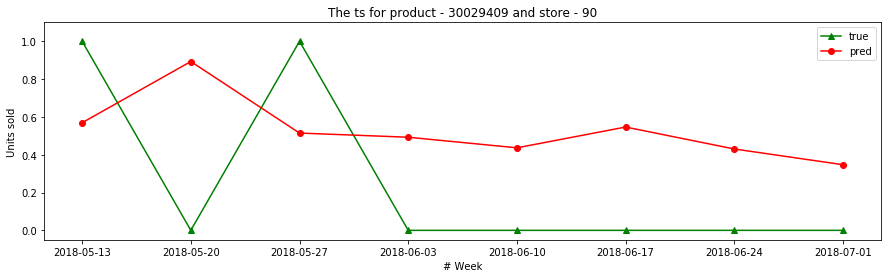

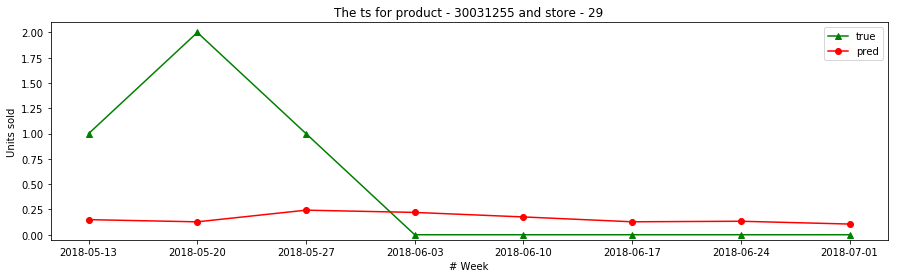

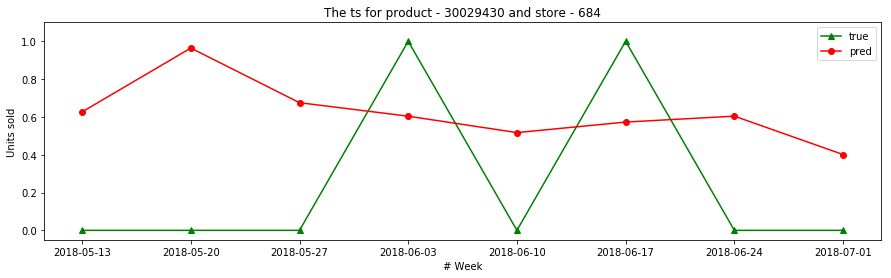

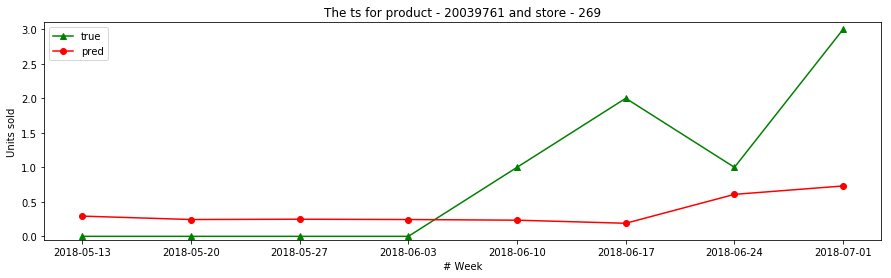

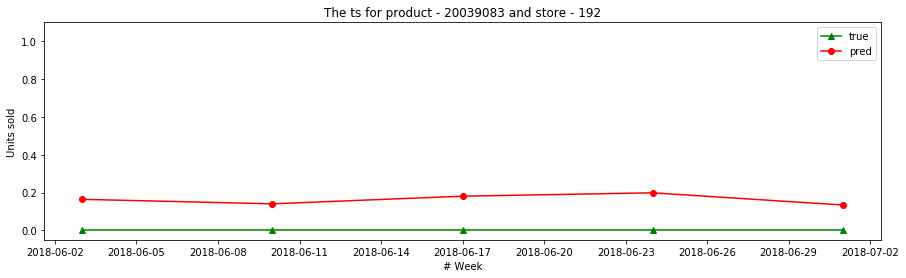

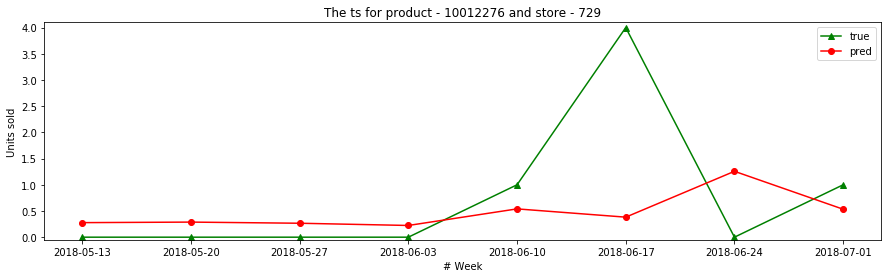

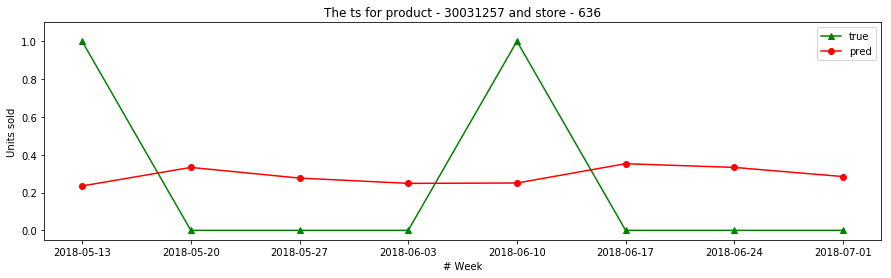

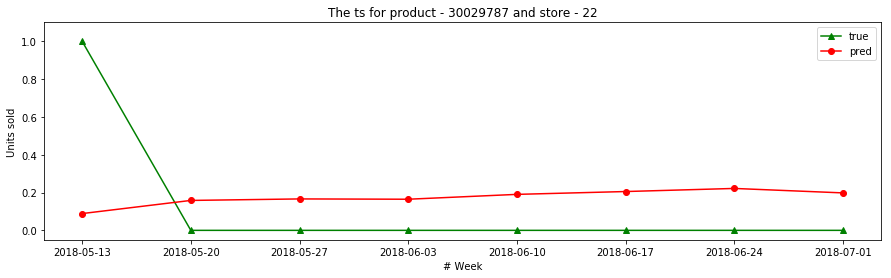

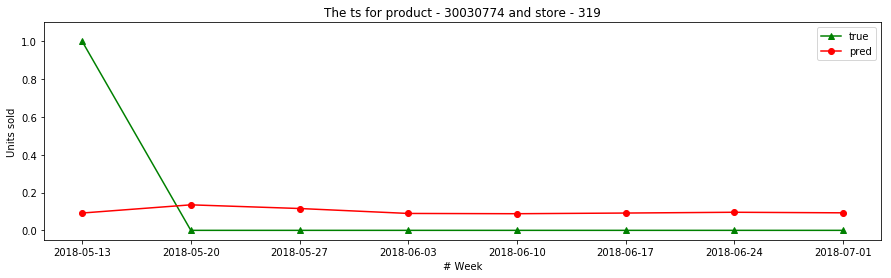

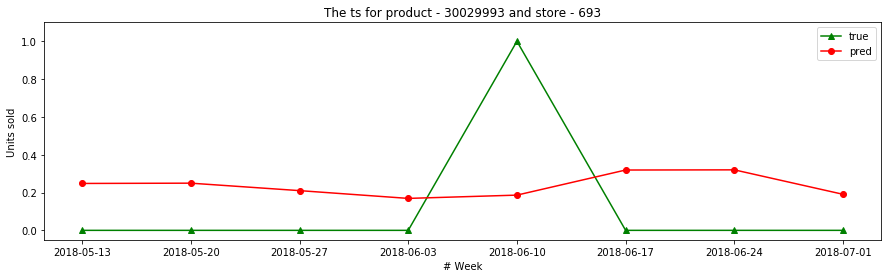

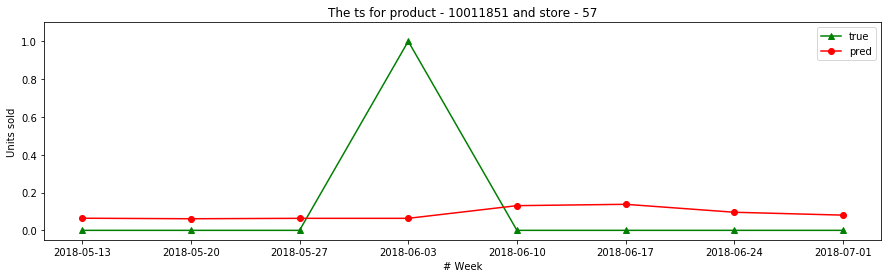

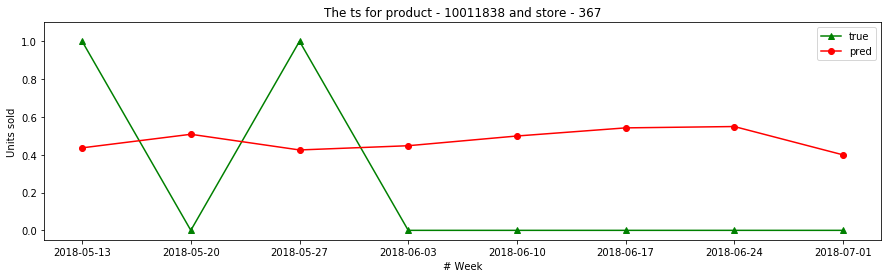

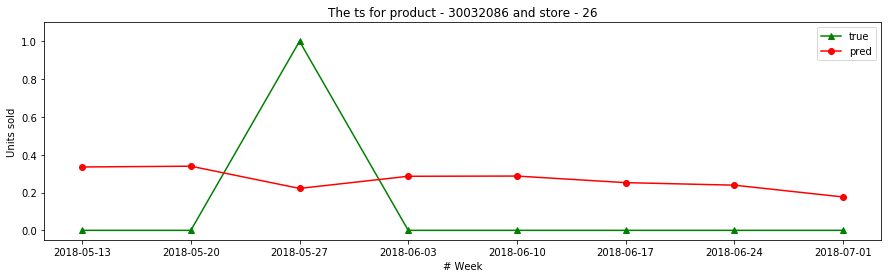

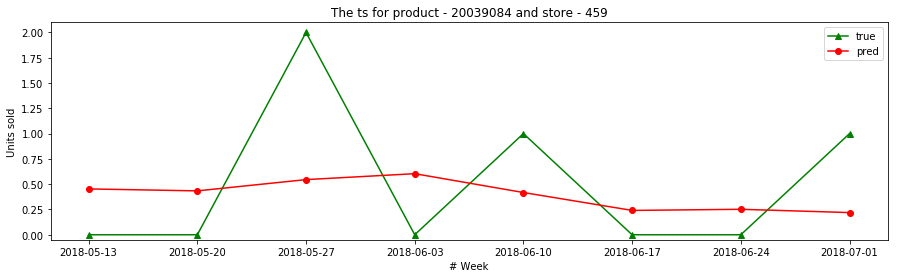

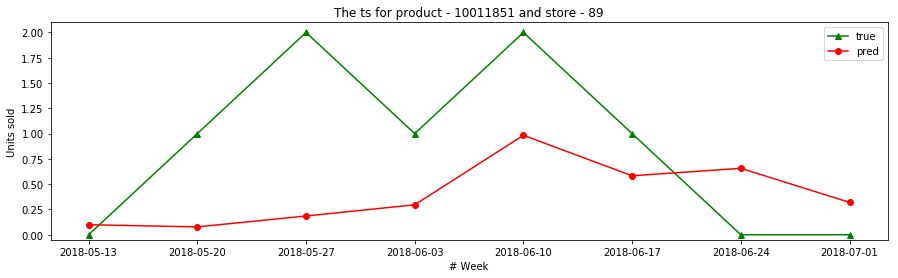

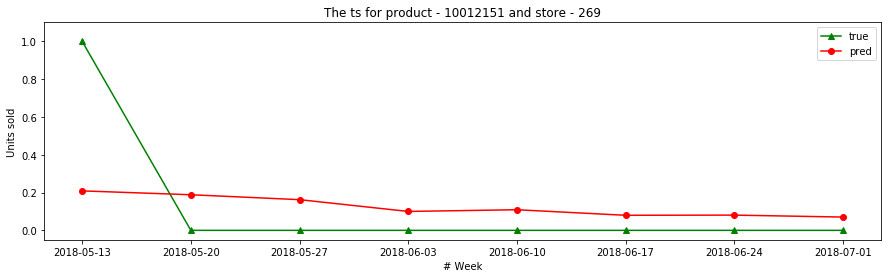

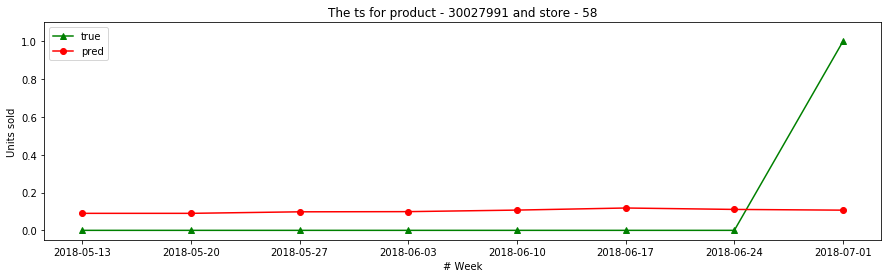

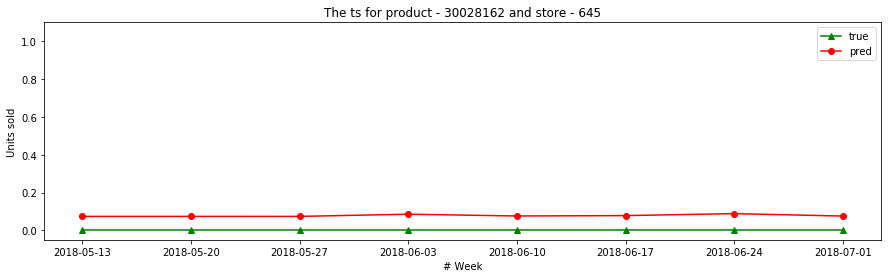

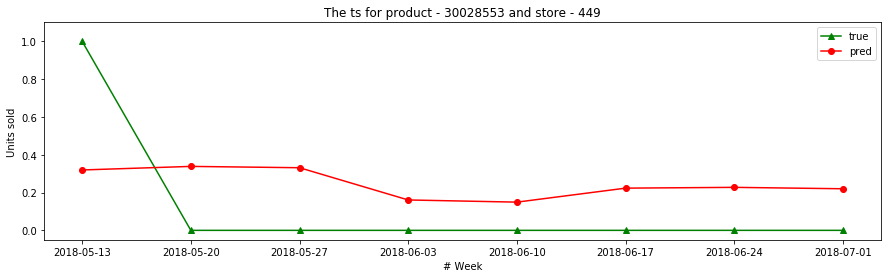

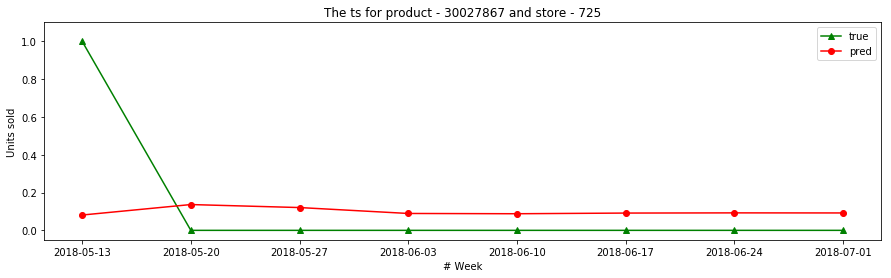

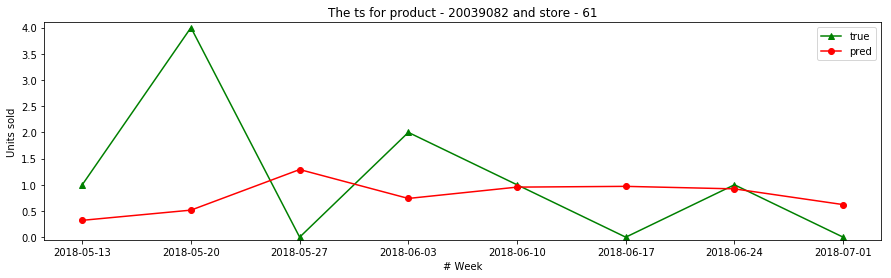

In [50]:
pairs = list(set(zip(res3['STORE_ID'], res3['PRODUCT_ID'])))

for i in range(len(pairs) // 100):
    store_id, product_id = pairs[i]
    plot_ts(res3, store_id, product_id)

In [51]:
res4 = pd.read_parquet('/main/data/MVideo_2/dataset_res_5_baseline.parquet')

In [52]:
res4.rename(columns = {'PRED_P1': 'PRED_P1_OLD'}, inplace = True)

In [53]:
res4['PRED_P1'] = pred3

In [54]:
def plot_ts2(df, store_id, product_id):
    data_part = df[(df['STORE_ID'] == store_id) & (df['PRODUCT_ID'] == product_id)]
    week_range = data_part.DATE.drop_duplicates().sort_values().values
    #week_range = np.arange(data_part['DATE'].min(), data_part['DATE'].max())# + 1)
    ts = pd.DataFrame()
    ts['DATE'] = week_range
    df = pd.merge(ts, data_part, on = 'DATE', how = 'left')[['DATE', 'UNITS_SOLD_P1', 'PRED_P1_OLD', 'PRED_P1']].fillna(0)
    plt.figure(figsize=(15, 4))
    plt.plot(df['DATE'].values, df['UNITS_SOLD_P1'].values, 'g^-', label='true')
    plt.plot(df['DATE'].values, df['PRED_P1_OLD'].values, 'yo-', label='old_pred')
    plt.plot(df['DATE'].values, df['PRED_P1'].values, 'ro-', label='new_pred')
    plt.xlabel('# Week')
    plt.ylabel('Units sold')
    max_y = max(1, df['UNITS_SOLD_P1'].max(), df['PRED_P1_OLD'].max(), df['PRED_P1'].max())
    plt.ylim((-0.05, max_y + 0.1))
    plt.title('The ts for product - %s and store - %s' % (product_id, store_id))
    plt.legend(loc='best')
    plt.show()

In [ ]:
pairs = list(set(zip(res4['STORE_ID'], res4['PRODUCT_ID'])))

for i in range(len(pairs) // 100):
    store_id, product_id = pairs[i]
    plot_ts2(res4, store_id, product_id)